# Building thermics project
## 2A - Smart Cities
#### Angelo Gabriele Ianzano, Juan Calvo Santa Teresa, Mohsin Mehmood
[![Launch in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/caalvo/Smart_Cities_modelling/HEAD?filepath=SmartCities_BuildingThermics_Project.ipynb)
#
#



import libraries used

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from IPython.display import IFrame, display

import dm4bem

# Table of Contents

- [1. Introduction](#1-introduction)


- [2. Model](#2-model)  
  - [2.1 Initial Parameters](#21-initial-parameters)  
  - [2.2 Calculations](#22-calculations)  
    - [2.2.1 Conductance matrix](#221-conductance-matrix)  
    - [2.2.2 Thermal resistances](#222-thermal-resistances)  
    - [2.2.3 Incidence matrix and output temperature vector](#223-incidence-matrix-and-output-temperature-vector)  
    - [2.2.4 Temperature source vector](#224-temperature-source-vector)  
    - [2.2.5 Flow rate source vector](#225-flow-rate-source-vector)  
    - [2.2.6 Capacitance matrix](#226-capacitance-matrix)


- [3. Steady State](#3-steady-state)  
  - [3.1 Steady state equation](#31-steady-state-equation)  
  - [3.2 Tested scenarios with steady state](#32-tested-scenarios-with-steady-state)  
    - [3.2.1 Winter without people or electrical appliances](#321-winter-without-people-or-electrical-appliances)  
    - [3.2.2 Winter with people and electrical appliances](#322-winter-with-people-and-electrical-appliances)  
    - [3.2.3 Summer without people or electrical appliances](#323-summer-without-people-or-electrical-appliances)  
    - [3.2.4 Summer with people and electrical appliances](#324-summer-with-people-and-electrical-appliances)


- [4. State space](#4-state-space)  
  - [4.1 Tested Scenarios with state space](#41-tested-scenarios-with-state-space)  
    - [4.1.1 Winter without people or electrical appliances](#411-winter-without-people-or-electrical-appliances)  
    - [4.1.2 Winter with people and electrical appliances](#412-winter-with-people-and-electrical-appliances)  
    - [4.1.3 Summer without people or appliances](#413-summer-without-people-or-appliances)  
    - [4.1.4 Summer with people and electrical appliances](#414-summer-with-people-and-electrical-appliances)  
  - [4.2 Analysing the state space model](#42-analysing-the-state-space-model)  
    - [4.2.1 Comparing with the steady state](#421-comparing-with-the-steady-state)  
    - [4.2.2 Eigenvalue analysis and time constants](#422-eigenvalue-analysis-and-time-constants)


- [5. Step response](#5-step-response)

- [6. Conclusions](#6-conclusions)

# 1. Introduction

This project, part of the Smart Cities course, focuses on the thermal modeling of buildings, aiming to achieve a realistic and physically consistent simulation of heat exchange dynamics. The objective is to analyse thermal behavior under both steady-state and transient conditions using a structured approach grounded in energy balance equations. A state-space representation is derived to enable time-domain simulations and system analysis. The methodology emphasizes verification against steady-state solutions to ensure numerical consistency and correctness. This model serves as a foundation for future applications in building energy management systems and predictive control strategies, which are critical components in the development of energy-efficient smart cities.


# 2. Model

## 2.1 Initial Parameters

House layout:

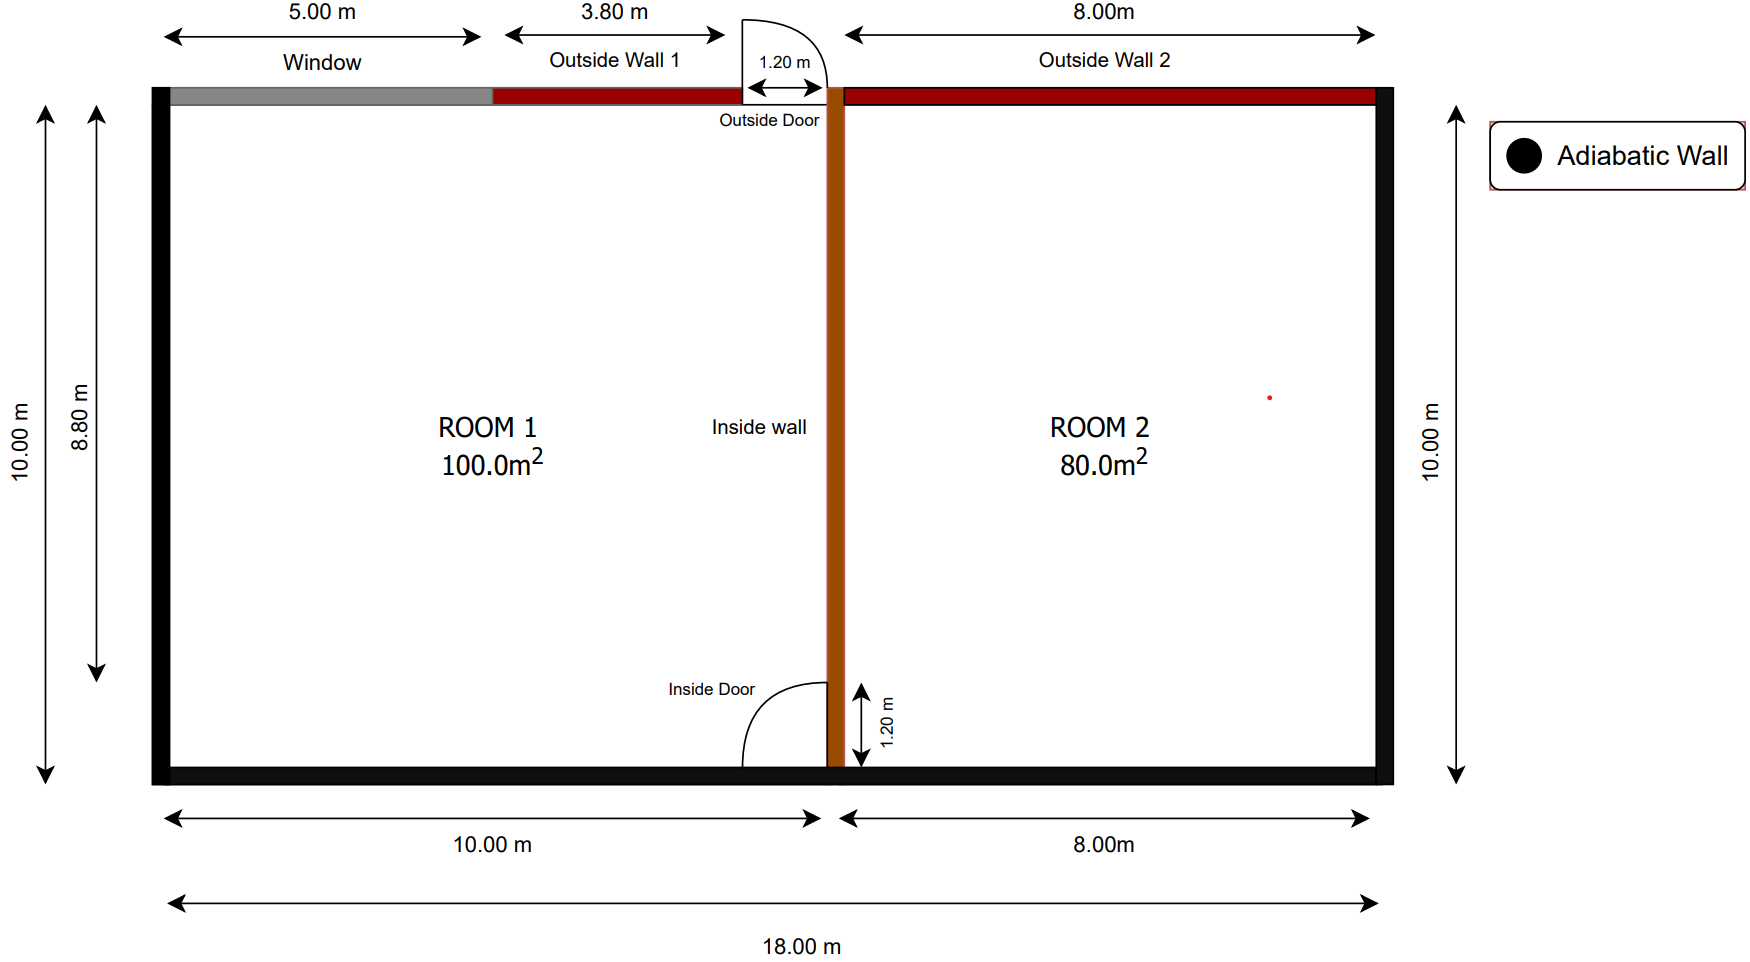

The insulation on the outside walls is in the exterior part of the building


Thermal circuit: 

In [3]:
IFrame("Updated Circuit.drawio.pdf", width=850, height=1000)

Physical constants and surface area of the elements in the room

Values for the doors obtained from:

Inside door: https://splendoor.pl/913/l1-2-3-4-5-6-7-8 

Outside door: https://splendoor.pl/426/passive-alu-f1 

Windows: https://splendoor.pl/944/systemy-okienne-standard

Indoor and outdoor wall: https://www.nachi.org/gallery/infrared-1/thermal-properties-of-materials 

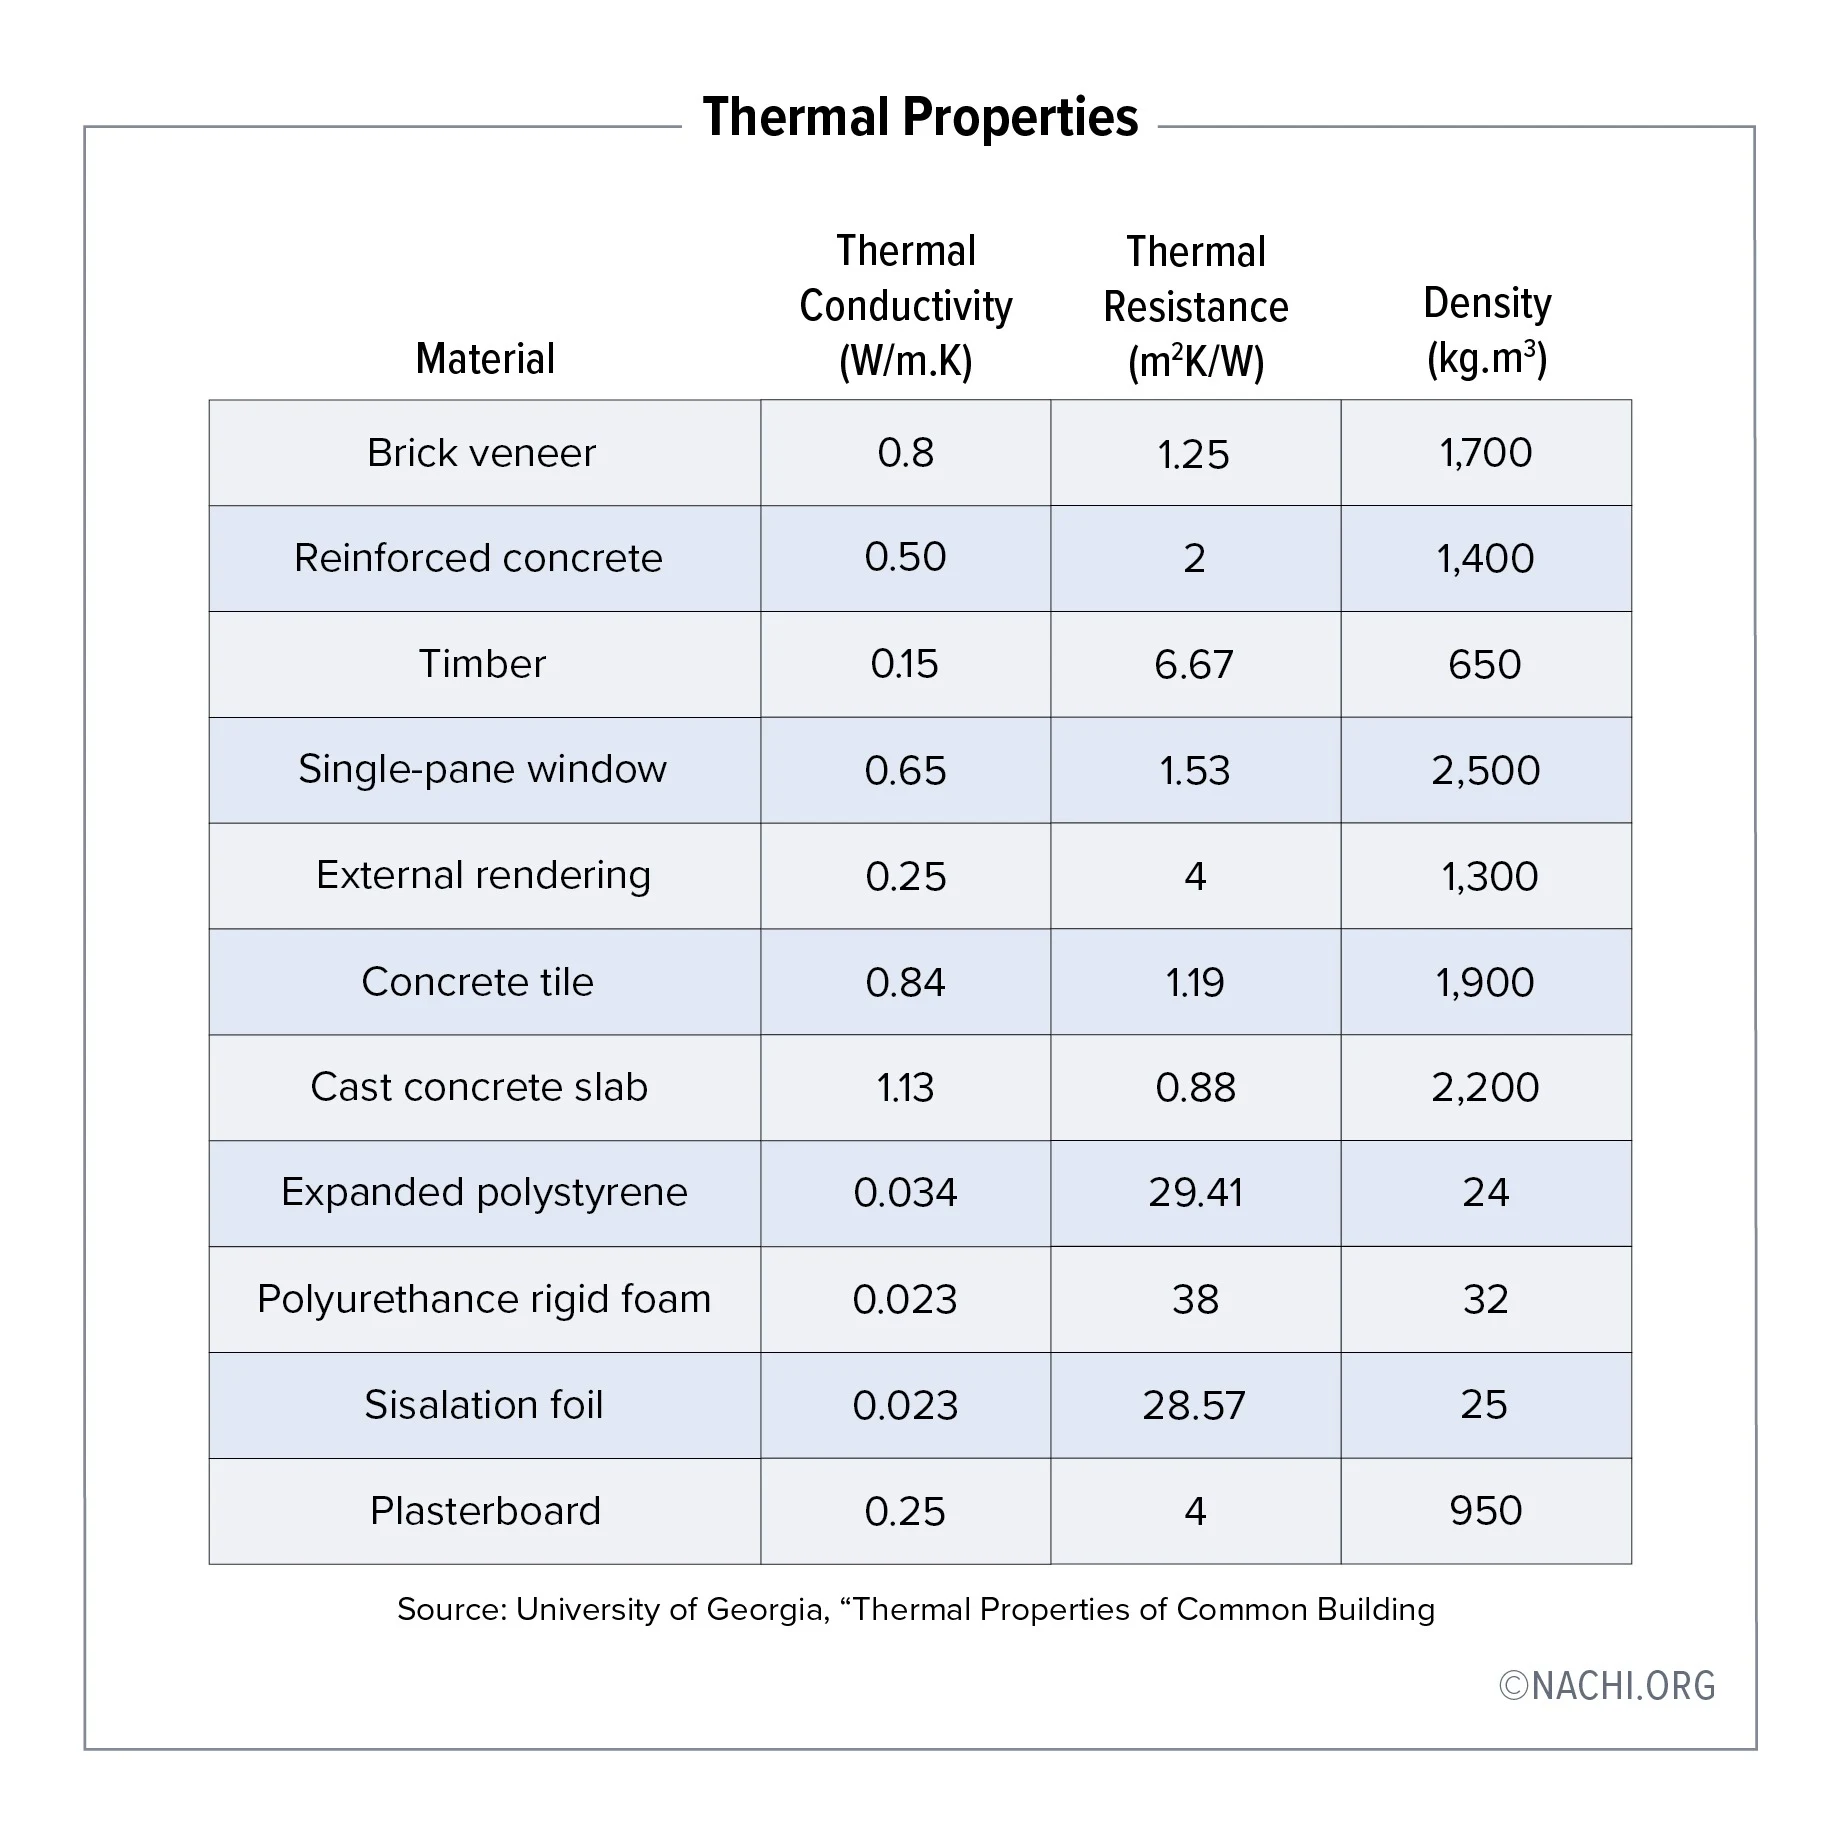
IFrame("Thermal Circuit.pdf", width=800, height=600)
    
    For the inside wall plasterboard was the selected material
    For the outside wall brick veneer was the selected material

Insulation (Glass mineral wool insulation): https://pim.knaufinsulation.com/files/download/epd_gmw_040_046_apac_cln_4.pdf 

Other data is obtained from examples from class.


In [3]:
# Air density
air_density = 1.2 # kg/m3
air_cp = 1000 # J/Kg*K

# Surface area of the floor of the rooms
S1 = 100 # m2
S2 = 80 # m2

height_room = 2.5 # m

# Surface areas
S_iw = 8.8 * height_room # m2 - iw = inside wall
S_ow1 = 3.8 * height_room # m2 - ow1 = outside wall 1
S_ow2 = 8 * height_room # m2 - ow2 = outside wall 2
S_door = 1.2 * height_room # m2 - both inside and outside doors have the same surface area
S_window = 5 * height_room # m2
S_total_room1 = S_iw + S_ow1 + 2 * S1 + 2 * 10 * height_room
S_total_room2 = S_iw + S_ow2 * 2 + S2 * 2 + 10 * height_room

# Heat flows 
# Solar erradiance
E_sun = 80 # W/m2
# Absorbtivity of our walls (white walls)
alpha = 0.2
# Walls
Phi_Sun_r1_iw = alpha * E_sun * S_iw / S_total_room1  # Phi_Sun, room 1, interior wall
Phi_Sun_r1_ow = alpha * E_sun * S_ow1 / S_total_room1  # Phi_Sun, room 1, outside wall but inside
Phi_Sun_r1_ew = alpha * E_sun * S_ow1  # Phi_Sun, room 1, outside wall in the exterior
Phi_Sun_r2_ew = alpha * E_sun * S_ow2  # Phi_Sun, room 2, outside wall in the exterior

# Convection coefficients
h_in = 4 # W/m2*K between inside air and wall
h_out = 10 # W/m2*K between outside air and wall

# Thermal values
Uvalue_id = 0.63 # W/m2*K
Uvalue_od = 0.71 # W/m2*K
Uvalue_window = 1.0 # W/m2*K

lambda_iw = 0.25 # W/m*K
width_iw = 0.2 # m
density_iw = 1000 # kg/m3
cp_iw = 840 # J/kg*K

lambda_ow = 0.8 # W/m*K
width_ow = 0.3 # m
density_ow = 1800 # kg/m3
cp_ow = 900 # J/kg*K

lambda_ins = 0.43 # W/m*K - ins = insulation
width_ins = 0.15 # m
density_ins = 9 # kg/m3
cp_ins = 840 # J/kg*K

# Controllers
Ksp = 1e3 # Perfect controller

## 2.2 Calculations

### 2.2.1 Conductance matrix
G is a diagonal matrix containing the thermal conductance values for each branch. Conductance is the inverse of thermal resistance and indicates how easily heat can 
flow through the material. Each diagonal entry corresponds to a particular heat transfer path such as a wall segment, window, or door.

In [4]:
def G_matrix(controller: bool):

    ''' 
    This function creates the matrix G depending on if we want controllers or not. 
    If controller = True, the G value of the controllers is equal to the Ksp.
    If controller = False, the G value of the controllers is set to non existant and therefore
    the G matrix is smaller as those last two numbers in the diagonal do not exist as the 
    controllers are disconected.
    The output is a DataFrame of the G matrix.
    '''
    
    # Window
    G_0 = Uvalue_window * S_window

    # Inside Wall
    G_1 = h_in * S_iw
    G_2 = lambda_iw * S_iw / (width_iw * 2)
    G_3 = G_2
    G_4 = G_1

    # Inside Door
    G_5 = Uvalue_id * S_door

    # Outside Wall 1
    G_6 = h_out * S_ow1
    G_7 = lambda_ins * S_ow1 / (width_ins * 2)
    G_8 = G_7
    G_9 = lambda_ow * S_ow1 / (width_ow * 2)
    G_10 = G_9
    G_11 = h_in * S_ow1

    # Outside Wall 2
    G_12 = h_out * S_ow2
    G_13 = lambda_ins * S_ow2 / (width_ins * 2)
    G_14 = G_13
    G_15 = lambda_ow * S_ow2 / (width_ow * 2)
    G_16 = G_15
    G_17 = h_in * S_ow2

    # Outside Door
    G_18 = Uvalue_od * S_door

    # Base values
    G_values = [
        G_0, G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9, G_10,
        G_11, G_12, G_13, G_14, G_15, G_16, G_17, G_18
    ]

    # If controller is active, add the 2 additional gains
    if controller:
        G_19 = Ksp
        G_20 = Ksp
        G_values += [G_19, G_20]

    # Create diagonal matrix
    G_np = np.diag(G_values)

    # Label for DataFrame
    labels = [f'G_{i}' for i in range(len(G_values))]
    G_df = pd.DataFrame(G_np, index=labels, columns=labels)

    return G_df

# G_winter0 = G_matrix(controller=True)  # test
# G_winter0.style.format("{:.2f}")  # Test

### 2.2.2 Thermal resistances
Thermal resistances represent how much a material or system resists the flow of heat. It's the thermal equivalent of electrical resistance. In this project we are not going to use them for calculations since we are using its inverse, the conductance.

In [5]:
# Example of a G with no controllers to show the thermal resistances
G = G_matrix(controller=False)

# Calculating the thermal resistances using G indices
Rth_window = 1 / G.iloc[0, 0]   # G_0
Rth_id     = 1 / G.iloc[5, 5]   # G_5
Rth_od     = 1 / G.iloc[18, 18] # G_18

Rth_iw  = 1 / (G.iloc[1, 1] + G.iloc[2, 2] + G.iloc[3, 3] + G.iloc[4, 4])
Rth_ow1 = 1 / sum(G.iloc[i, i] for i in [6, 7, 8, 9, 10, 11])
Rth_ow2 = 1 / sum(G.iloc[i, i] for i in [12, 13, 14, 15, 16, 17])

# Create a table of results
rth_table = pd.DataFrame({
    "Element": [
        "Window",
        "Inside door",
        "Outside door",
        "Inside wall",
        "Outside wall 1",
        "Outside wall 2"
    ],
    "Thermal Resistance (K/W)": [
        Rth_window,
        Rth_id,
        Rth_od,
        Rth_iw,
        Rth_ow1,
        Rth_ow2
    ]
})

rth_table.style.format({"Thermal Resistance (K/W)": "{:.6f}"}).hide(axis="index")

Element,Thermal Resistance (K/W)
Window,0.080000
Inside door,0.529101
Outside door,0.469484
Inside wall,0.004914
Outside wall 1,0.005389
Outside wall 2,0.002560


### 2.2.3 Incidence matrix and output temperature vector
The incidence matrix A defines the connections between thermal resistances (branches) and temperature nodes. Each row corresponds to a branch (such as a wall, window, or door), and 
each column corresponds to a node (temperature point in the system). The matrix is populated with 1, -1, or 0 values, depending on how a branch enters or exits a node.

The output temperature vector monitors the temperature of the nodes that are of interest. In the case of this study, this nodes would be nodes 0 and 4, which are the nodes for the temperature in the rooms. It is represented by vector y.

In [6]:
def A_matrix_y_vector(controller: bool):

    '''
    This function creates matrix A and vector y.
    If controller = True, the two connections of them are added to the matrix.
    If controller = False, the two connections of them are removed, as they are
    disconnected from the system.
    The output is a DataFrame with matrix A and a np vector y which varies accordingly 
    to the size of matrix A.
    '''
    
    # Full-size matrix A
    A = np.zeros((21, 15))

    # Assign fixed non-zero values
    A[0, 0] = 1
    A[1, 0] = -1
    A[1, 1] = 1
    A[2, 1] = -1
    A[2, 2] = 1
    A[3, 2] = -1
    A[3, 3] = 1
    A[4, 3] = -1
    A[4, 4] = 1
    A[5, 0] = -1
    A[5, 4] = 1
    A[6, 10] = 1
    A[7, 10] = -1
    A[7, 11] = 1
    A[8, 11] = -1
    A[8, 12] = 1
    A[9, 12] = -1
    A[9, 13] = 1
    A[10, 13] = -1
    A[10, 14] = 1
    A[11, 14] = -1
    A[11, 0] = 1
    A[12, 9] = 1
    A[13, 8] = 1
    A[13, 9] = -1
    A[14, 8] = -1
    A[14, 7] = 1
    A[15, 7] = -1
    A[15, 6] = 1
    A[16, 6] = -1
    A[16, 5] = 1
    A[17, 5] = -1
    A[17, 4] = 1
    A[18, 0] = 1
    A[19, 4] = 1
    A[20, 0] = 1

    # If no controller, remove rows 19 and 20
    if not controller:
        A = np.delete(A, [19, 20], axis=0)

    # Create labeled DataFrame
    row_labels = [f"row_{i}" for i in range(A.shape[0])]
    col_labels = [f"col_{j}" for j in range(A.shape[1])]
    A_df = pd.DataFrame(A.astype(int), index=row_labels, columns=col_labels)

    # Create vector b according to the size of vector a
    y = np.zeros(A.shape[1])
    y[0] = 1
    y[4] = 1


    return A_df, y

### 2.2.4 Temperature source vector
The temperature vector b defines at which q there is a fixed potential, that could be either the outside temperature or the set temperature. The lenght of the vector is as the number of q we have in out model.

In [7]:
def b_vector(To: float, controller: bool, Tsp: float = None):
    if controller and Tsp is None:
        raise ValueError("Tsp must be provided when controller=True.")

    '''
    This function creates vector b.
    The user inputs To, the outside temperature,
    controller = True/False, which adds or eliminates the Tsp settings,
    and if controller = True, the user must provide a value for the Tsp.
    The output is a np vector b.
    '''

    # Base b values (length 19)
    b = [
        To,
        0, 0, 0, 0, 0,
        To,
        0, 0, 0, 0, 0,
        To,
        0, 0, 0, 0, 0,
        To
    ]

    # Add setpoint temps if controller is used
    if controller:
        b += [Tsp, Tsp]  # total length: 21

    return np.array(b)

### 2.2.5 Flow rate source vector
The flow-rate source vector f represents internal heat generation such as from occupants, solar gains, or electrical appliances. It is the same length as the number 
of branches in the thermal network. It is often zero during steady-state simulations unless specific heat sources are applied.

In [8]:
def f_vector(people: bool, appliances: bool, n_people: int = None, Phi_elec: float = None):

    '''
    This function creates vector f.
    It allows the user to decide if there are people in room 1, and
    the user can select how many people there are, which is then 
    multiplied by 80, following the hypothesis that a person generates 
    80 W.
    It also allows the user to decide if there are appliances in room 2,
    and the user can select how many W the appliances produce.
    The output is np array vector f.
    '''
    
    # Handle Phi_people
    Phi_people = n_people * 80 if people else 0

    # Handle Phi_elec
    Phi_elec = Phi_elec if appliances else 0

    # Return the vector (requires solar gains to be defined beforehand)
    f = np.array([
        Phi_people, 
        Phi_Sun_r1_iw, 
        0, 0, 
        Phi_elec, 
        0, 0, 0, 0, 
        Phi_Sun_r2_ew, 
        Phi_Sun_r1_ew, 
        0, 0, 0, 
        Phi_Sun_r1_ow
    ])

    return f

### 2.2.6 Capacitance matrix
C is a diagonal matrix representing thermal capacitance at nodes. This matrix models the heat storage capacity of building elements such as walls, doors, and air volumes. 
It determines how slowly or quickly the temperature at a node change in response to heat input.

In [9]:
C = np.zeros((15, 15))

C[2, 2] = density_iw * cp_iw * S_iw * width_iw
C[6, 6] = density_ow * cp_ow * S_ow2 * width_ow
C[8, 8] = density_ins * cp_ins * S_ow2 * width_ins
C[13, 13] = density_ow * cp_ow * S_ow1 * width_ow
C[11, 11] = density_ins * cp_ins * S_ow1 * width_ins

C_df = pd.DataFrame(C.astype(int), index=[f"row_{i}" for i in range(15)],
                       columns=[f"col_{j}" for j in range(15)])

C_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
row_0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_2,0,0,3696000,0,0,0,0,0,0,0,0,0,0,0,0
row_3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_6,0,0,0,0,0,0,9720000,0,0,0,0,0,0,0,0
row_7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_8,0,0,0,0,0,0,0,0,22680,0,0,0,0,0,0
row_9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 3. Steady State

## 3.1 Steady state equation
This is the steady state equation useful to calculate the output node temperatures and the flow rates:
$$
\left\{
\begin{aligned}
\theta &= \left(A^T G A \right)^{-1} \left( A^T G b + f \right) \\
q &= G \left( -A \theta + b \right)
\end{aligned}
\right.
$$

## 3.2 Tested scenarios with steady state

We will show four scenarios, two in winter, two in the summer, and with or without people and electrical appliances in the room; but first we will check that our model is correct by setting the values for the flow rate source vector, f, to zero. We should obtain the same temperature in all the nodes, with the temperature shown being the outside temperature

In [10]:
# Define scenario
controller = False # for the steady state analysis there are no controllers
To = 5 # outside temperature of 5º C for winter
people = False
appliances = False

# Build system matrices and vectors
G = G_matrix(controller)
A, y = A_matrix_y_vector(controller)
b = b_vector(To=To, controller=controller)
f = np.zeros(15,)

# Convert to NumPy
G_np = G.values
A_np = A.values

# Ensure b and f are 2D column vectors
b_vec = b.reshape(-1, 1)  # (19, 1)
f_vec = f.reshape(-1, 1)  # (15, 1)

# Compute steady-state temperatures
θ_vec = np.linalg.inv(A_np.T @ G_np @ A_np) @ (A_np.T @ G_np @ b_vec + f_vec)
θ = θ_vec.flatten()  # Convert back to 1D if needed

# Compute flow rates
q = G_np @ (-A_np @ θ + b)

# Temperature vector in steady-state
# θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

# Display results
print("\n\nResults of the steady state analysis:")
print("Steady-state Temperatures θ (°C):")
display(pd.DataFrame(θ, columns=["θ"]).T.style.format("{:.2f}"))

print("Steady-state Flow Rates q (W):")
display(pd.DataFrame(q, columns=["q"]).T.style.format("{:.2f}"))



Results of the steady state analysis:
Steady-state Temperatures θ (°C):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
θ,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


Steady-state Flow Rates q (W):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
q,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00


Once the model works, we can make it into a function for ease of use:

In [11]:
def steady_state_dae(To: float, 
                     people: bool, 
                     n_people: int = 0,   
                     appliances: bool = False, 
                     Phi_elec: float = 0.0,
                     controller: bool = False, 
                     Tsp: float = None):
    """
    Computes the steady-state solution (DAE-based) and returns all components.

    Parameters:
    - To: outdoor temperature (°C)
    - people: whether people are present in room 1
    - n_people: number of people in room 1
    - appliances: whether electrical appliances are present in room 2
    - Phi_elec: power output from appliances (W)
    - controller: whether controllers are used
    - Tsp: setpoint temperature if controller is True

    Returns:
    - θ: temperature vector (1D)
    - q: flow rate vector (1D)
    - G, A, y, b, f: matrices and vectors used in computation
    """

    # Build system matrices and vectors
    G = G_matrix(controller)
    A, y = A_matrix_y_vector(controller)
    b = b_vector(To=To, controller=controller, Tsp=Tsp if controller else None)
    f = f_vector(people=people, appliances=appliances,
                 n_people=n_people, Phi_elec=Phi_elec)

    # Convert to NumPy
    G_np = G.values
    A_np = A.values

    # Ensure b and f are 2D column vectors
    b_vec = b.reshape(-1, 1)  # (19 or 21, 1)
    f_vec = f.reshape(-1, 1)  # (15, 1)

    # Compute steady-state temperatures
    θ_vec = np.linalg.inv(A_np.T @ G_np @ A_np) @ (A_np.T @ G_np @ b_vec + f_vec)
    θ = θ_vec.flatten()  # Convert back to 1D if needed

    # Compute flow rates
    q = G_np @ (-A_np @ θ + b)

    return θ, q, G, A, y, b, f


### 3.2.1 Winter without people or electrical appliances:
In this scenario we suppose that there is no people or electrical appliances in either room. Also, we suppose that as it is winter, there is an outside temperature of 5 ºC.

In [12]:
# Define scenario
controller = False # for the steady state analysis there are no controllers
To = 5 # outside temperature of 5º C for winter
people = False
appliances = False

[θ_w_wo, q, G, A, y, b, f] = steady_state_dae(To,   # θ_w_wo = θ WInter WithOut people or appliances. 
                                         people,
                                         appliances,
                                         controller)

print("Sizes of the matrices obtained:")
print(f"G: {G.shape} — Conductance matrix (square)")
print(f"A: {A.shape} — Incidence matrix")
print(f"y: {y.shape} — Output temperature vector")
print(f"b: {b.shape} — Temperature source vector")
print(f"f: {f.shape} — Flow rate source vector")
print(f"θ: {θ_w_wo.shape} — Steady-state temperature vector")
print(f"q: {q.shape} — Steady-state flow-rate vector")

# Display matrices and 
print("\nMatrices and vector with this hypothesis: \n")
print("Conductance Matrix G:")
display(G.style.format("{:.2f}"))

print("Incidence Matrix A:")
display(A.style.format("{:d}"))

print("Output Temperature Vector y:")
display(pd.DataFrame(y, columns=["y"]).T.style.format("{:.0f}"))

print("Temperature Source Vector b:")
display(pd.DataFrame(b, columns=["b"]).T.style.format("{:.2f}"))

print("Flow Rate Source Vector f:")
display(pd.DataFrame(f, columns=["f"]).T.style.format("{:.2f}"))


# Display results
print("\n\nResults of the steady state analysis:")
print("Steady-state Temperatures θ (°C):")
display(pd.DataFrame(θ_w_wo, columns=["θ"]).T.style.format("{:.2f}"))

print("Steady-state Flow Rates q (W):")
display(pd.DataFrame(q, columns=["q"]).T.style.format("{:.2f}"))

Sizes of the matrices obtained:
G: (19, 19) — Conductance matrix (square)
A: (19, 15) — Incidence matrix
y: (15,) — Output temperature vector
b: (19,) — Temperature source vector
f: (15,) — Flow rate source vector
θ: (15,) — Steady-state temperature vector
q: (19,) — Steady-state flow-rate vector

Matrices and vector with this hypothesis: 

Conductance Matrix G:


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,G_17,G_18
G_0,12.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_1,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_2,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_3,0.00,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_4,0.00,0.00,0.00,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_5,0.00,0.00,0.00,0.00,0.00,1.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_6,0.00,0.00,0.00,0.00,0.00,0.00,95.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Incidence Matrix A:


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
row_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
row_2,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0
row_3,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0
row_4,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0
row_5,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
row_6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
row_7,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0
row_8,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0
row_9,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0


Output Temperature Vector y:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Temperature Source Vector b:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
b,5.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,5.00


Flow Rate Source Vector f:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
f,0.00,1.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,320.00,152.00,0.00,0.00,0.00,0.54




Results of the steady state analysis:
Steady-state Temperatures θ (°C):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
θ,5.57,5.61,5.80,6.00,6.03,6.07,6.20,6.34,6.46,6.58,6.57,6.35,6.13,5.90,5.66


Steady-state Flow Rates q (W):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
q,-7.09,-3.91,-2.65,-2.65,-2.65,-0.87,-149.02,2.98,2.98,2.98,2.98,3.52,-316.47,3.53,3.53,3.53,3.53,3.53,-1.21


As we can see, in this scenario we got such low values in our rooms, very close to the outside temperature, since the only heat flow sources come from the sun irradiance.

### 3.2.2 Winter with people and electrical appliances
In this scenario we suppose it is winter, so there is an outside temperature of 5 ºC, and that in room 1 there are two people, with the hypothesis that each person generates 80W, generating a total of 160 W, and that in room 2 there are electrical appliances generating 250 W.

In [13]:
# Define scenario
controller = False         
To = 5                                           
people = True
n_people = 2
appliances = True
Phi_elec = 250 # W

[θ_w_wpa, q, G, A, y, b, f] = steady_state_dae(To,    # θ_w_wpa = θ Winter With People and Appliances
                                         people, 
                                         n_people,
                                         appliances,
                                         Phi_elec,
                                         controller)

print("Sizes of the matrices obtained:")
print(f"G: {G.shape} — Conductance matrix (square)")
print(f"A: {A.shape} — Incidence matrix")
print(f"y: {y.shape} — Output temperature vector")
print(f"b: {b.shape} — Temperature source vector")
print(f"f: {f.shape} — Flow rate source vector")
print(f"θ: {θ_w_wpa.shape} — Steady-state temperature vector")
print(f"q: {q.shape} — Steady-state flow-rate vector")

# Display matrices and vectors
print("\nMatrices and vector with this hypothesis: \n")
print("Conductance Matrix G:")
display(G.style.format("{:.2f}"))

print("Incidence Matrix A:")
display(A.style.format("{:d}"))

print("Output Temperature Vector y:")
display(pd.DataFrame(y, columns=["y"]).T.style.format("{:.0f}"))

print("Temperature Source Vector b:")
display(pd.DataFrame(b, columns=["b"]).T.style.format("{:.2f}"))

print("Flow Rate Source Vector f:")
display(pd.DataFrame(f, columns=["f"]).T.style.format("{:.2f}"))


# Display results
print("\n\nResults of the steady state analysis:")
print("Steady-state Temperatures θ (°C):")
display(pd.DataFrame(θ_w_wpa, columns=["θ"]).T.style.format("{:.2f}"))

print("Steady-state Flow Rates q (W):")
display(pd.DataFrame(q, columns=["q"]).T.style.format("{:.2f}"))

Sizes of the matrices obtained:
G: (19, 19) — Conductance matrix (square)
A: (19, 15) — Incidence matrix
y: (15,) — Output temperature vector
b: (19,) — Temperature source vector
f: (15,) — Flow rate source vector
θ: (15,) — Steady-state temperature vector
q: (19,) — Steady-state flow-rate vector

Matrices and vector with this hypothesis: 

Conductance Matrix G:


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,G_17,G_18
G_0,12.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_1,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_2,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_3,0.00,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_4,0.00,0.00,0.00,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_5,0.00,0.00,0.00,0.00,0.00,1.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_6,0.00,0.00,0.00,0.00,0.00,0.00,95.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Incidence Matrix A:


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
row_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
row_2,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0
row_3,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0
row_4,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0
row_5,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
row_6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
row_7,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0
row_8,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0
row_9,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0


Output Temperature Vector y:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Temperature Source Vector b:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
b,5.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,5.00


Flow Rate Source Vector f:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
f,160.00,1.25,0.00,0.00,250.00,0.00,0.00,0.00,0.00,320.00,152.00,0.00,0.00,0.00,0.54




Results of the steady state analysis:
Steady-state Temperatures θ (°C):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
θ,19.85,20.67,25.87,31.07,31.88,29.93,24.09,18.25,12.81,7.38,7.01,9.86,12.71,15.77,18.84


Steady-state Flow Rates q (W):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
q,-185.57,-72.72,-71.47,-71.47,-71.47,-22.74,-190.81,-38.81,-38.81,-38.81,-38.81,-38.27,-475.79,-155.79,-155.79,-155.79,-155.79,-155.79,-31.62


In this scenario we obtained respectively around 20°C and 30°C in room 1 and room 2. As a first impression they seem such high values if compared to the outside temperatures. But if we consider that the insulation of our building is very good (insulated walls + adiabatic walls) and that we are in steady state, the heat generation inside the both rooms will affect a lot their temperatures.

### 3.2.3 Summer without people or electrical appliances
This scenario is done in summer with an outside temperature of 25 ºC and with no people or electrical appliances in either room.

In [14]:
# Define scenario
controller = False # for the steady state analysis there are no controllers
To = 25 # outside temperature of 25º C for summer
people = False
appliances = False

[θ_s_wo, q, G, A, y, b, f] = steady_state_dae(To,   # θ_s_wo = θ Summer WithOut people or appliances
                                         people, 
                                         n_people,
                                         appliances,
                                         Phi_elec,
                                         controller)

print("Sizes of the matrices obtained:")
print(f"G: {G.shape} — Conductance matrix (square)")
print(f"A: {A.shape} — Incidence matrix")
print(f"y: {y.shape} — Output temperature vector")
print(f"b: {b.shape} — Temperature source vector")
print(f"f: {f.shape} — Flow rate source vector")
print(f"θ: {θ_s_wo.shape} — Steady-state temperature vector")
print(f"q: {q.shape} — Steady-state flow-rate vector")

# Display matrices and 
print("\nMatrices and vector with this hypothesis: \n")
print("Conductance Matrix G:")
display(G.style.format("{:.2f}"))

print("Incidence Matrix A:")
display(A.style.format("{:d}"))

print("Output Temperature Vector y:")
display(pd.DataFrame(y, columns=["y"]).T.style.format("{:.0f}"))

print("Temperature Source Vector b:")
display(pd.DataFrame(b, columns=["b"]).T.style.format("{:.2f}"))

print("Flow Rate Source Vector f:")
display(pd.DataFrame(f, columns=["f"]).T.style.format("{:.2f}"))


# Display results
print("\n\nResults of the steady state analysis:")
print("Steady-state Temperatures θ (°C):")
display(pd.DataFrame(θ_s_wo, columns=["θ"]).T.style.format("{:.2f}"))

print("Steady-state Flow Rates q (W):")
display(pd.DataFrame(q, columns=["q"]).T.style.format("{:.2f}"))

Sizes of the matrices obtained:
G: (19, 19) — Conductance matrix (square)
A: (19, 15) — Incidence matrix
y: (15,) — Output temperature vector
b: (19,) — Temperature source vector
f: (15,) — Flow rate source vector
θ: (15,) — Steady-state temperature vector
q: (19,) — Steady-state flow-rate vector

Matrices and vector with this hypothesis: 

Conductance Matrix G:


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,G_17,G_18
G_0,12.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_1,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_2,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_3,0.00,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_4,0.00,0.00,0.00,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_5,0.00,0.00,0.00,0.00,0.00,1.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_6,0.00,0.00,0.00,0.00,0.00,0.00,95.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Incidence Matrix A:


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
row_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
row_2,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0
row_3,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0
row_4,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0
row_5,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
row_6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
row_7,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0
row_8,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0
row_9,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0


Output Temperature Vector y:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Temperature Source Vector b:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
b,25.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,25.00


Flow Rate Source Vector f:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
f,0.00,1.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,320.00,152.00,0.00,0.00,0.00,0.54




Results of the steady state analysis:
Steady-state Temperatures θ (°C):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
θ,25.57,25.61,25.80,26.00,26.03,26.07,26.20,26.34,26.46,26.58,26.57,26.35,26.13,25.90,25.66


Steady-state Flow Rates q (W):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
q,-7.09,-3.91,-2.65,-2.65,-2.65,-0.87,-149.02,2.98,2.98,2.98,2.98,3.52,-316.47,3.53,3.53,3.53,3.53,3.53,-1.21


As we got in the winter without the internal heat generation, the values are very close to the outside temperatures.

### 3.2.4 Summer with people and electrical appliances
This scenario is done in the summer, with 25ºC outside, and with two people in room 1 generating 160 W and electrical appliances in room 2 generating 250 W.

In [15]:
# Define scenario
controller = False         
To = 25                                         
people = True
n_people = 2
appliances = True
Phi_elec = 250 # W

[θ_s_wpa, q, G, A, y, b, f] = steady_state_dae(To,    # θ_s_wpa = θ Summer With People and Appliances
                                         people, 
                                         n_people,
                                         appliances,
                                         Phi_elec,
                                         controller)

print("Sizes of the matrices obtained:")
print(f"G: {G.shape} — Conductance matrix (square)")
print(f"A: {A.shape} — Incidence matrix")
print(f"y: {y.shape} — Output temperature vector")
print(f"b: {b.shape} — Temperature source vector")
print(f"f: {f.shape} — Flow rate source vector")
print(f"θ: {θ_s_wpa.shape} — Steady-state temperature vector")
print(f"q: {q.shape} — Steady-state flow-rate vector")

# Display matrices and 
print("\nMatrices and vector with this hypothesis: \n")
print("Conductance Matrix G:")
display(G.style.format("{:.2f}"))

print("Incidence Matrix A:")
display(A.style.format("{:d}"))

print("Output Temperature Vector y:")
display(pd.DataFrame(y, columns=["y"]).T.style.format("{:.0f}"))

print("Temperature Source Vector b:")
display(pd.DataFrame(b, columns=["b"]).T.style.format("{:.2f}"))

print("Flow Rate Source Vector f:")
display(pd.DataFrame(f, columns=["f"]).T.style.format("{:.2f}"))


# Display results
print("\n\nResults of the steady state analysis:")
print("Steady-state Temperatures θ (°C):")
display(pd.DataFrame(θ_s_wpa, columns=["θ"]).T.style.format("{:.2f}"))

print("Steady-state Flow Rates q (W):")
display(pd.DataFrame(q, columns=["q"]).T.style.format("{:.2f}"))

Sizes of the matrices obtained:
G: (19, 19) — Conductance matrix (square)
A: (19, 15) — Incidence matrix
y: (15,) — Output temperature vector
b: (19,) — Temperature source vector
f: (15,) — Flow rate source vector
θ: (15,) — Steady-state temperature vector
q: (19,) — Steady-state flow-rate vector

Matrices and vector with this hypothesis: 

Conductance Matrix G:


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,G_10,G_11,G_12,G_13,G_14,G_15,G_16,G_17,G_18
G_0,12.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_1,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_2,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_3,0.00,0.00,0.00,13.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_4,0.00,0.00,0.00,0.00,88.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_5,0.00,0.00,0.00,0.00,0.00,1.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_6,0.00,0.00,0.00,0.00,0.00,0.00,95.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
G_9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Incidence Matrix A:


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
row_0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
row_1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
row_2,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0
row_3,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0
row_4,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0
row_5,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
row_6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
row_7,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0
row_8,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0
row_9,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0


Output Temperature Vector y:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
y,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Temperature Source Vector b:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
b,25.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,25.00


Flow Rate Source Vector f:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
f,160.00,1.25,0.00,0.00,250.00,0.00,0.00,0.00,0.00,320.00,152.00,0.00,0.00,0.00,0.54




Results of the steady state analysis:
Steady-state Temperatures θ (°C):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
θ,39.85,40.67,45.87,51.07,51.88,49.93,44.09,38.25,32.81,27.38,27.01,29.86,32.71,35.77,38.84


Steady-state Flow Rates q (W):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
q,-185.57,-72.72,-71.47,-71.47,-71.47,-22.74,-190.81,-38.81,-38.81,-38.81,-38.81,-38.27,-475.79,-155.79,-155.79,-155.79,-155.79,-155.79,-31.62


As we obtained in the winter with internal heat generation, the rooms' temperatures are very high compared to the outside temperature: that's because, again, of the good insulation of this building and that we are considering the steady state situation, so after an 'infinite' time.

# 4. State space
The state-space model is derived from the energy balance equations formulated through thermal network analysis. These equations, in the form of differential-algebraic equations, are transformed into a first-order system of ordinary differential equations that describe how the state variables, the temperatures at nodes with thermal capacity, evolve over time.

We obtained the As, Bs, Cs, Ds from the Diferential Algebraic Equations (DAE) and obtained the values of the input vector $u = \left[ b_T^T, f_Q^T \right]^T.$ which is written as *us* in the code.

Once we obtained the matrices, we could obtain the steady-state response of the state-space representation.

In [16]:
def state_space_response(To: float, 
                         people: bool, 
                         n_people: int = 0,
                         appliances: bool = False, 
                         Phi_elec: float = 0.0,
                         controller: bool = False, 
                         Tsp: float = None):
    """
    Computes the state-space model and its steady-state response
    for a thermal building model using the dm4bem library.

    This version allows you to keep using numeric b_vector() and f_vector().

    Returns:
    - As, Bs, Cs, Ds: state-space matrices
    - us: input mapping (symbolic)
    - theta_ss: steady-state temperatures at capacitive nodes
    - y_ss: steady-state output temperatures
    """

    # Building the system matrices
    G = G_matrix(controller)
    A, y = A_matrix_y_vector(controller)

    # Getting the numerical vectors
    b_num = b_vector(To=To, controller=controller, Tsp=Tsp)
    f_num = f_vector(people=people, appliances=appliances,
                     n_people=n_people, Phi_elec=Phi_elec)

    # Converting numeric vectors into symbolic equivalents
    b_sym = [
        'To' if i in [0, 6, 12, 18] else
        'Tsp' if controller and i in [19, 20] else
        0
        for i in range(len(b_num))
    ]

    f_sym = [
        'Phi_people' if i == 0 and people else
        'Phi_iw' if i == 1 else
        'Phi_elec' if i == 4 and appliances else
        'Phi_ew2' if i == 9 else
        'Phi_ew1' if i == 10 else
        'Phi_ow1' if i == 14 else
        0
        for i in range(len(f_num))
    ]

    G_series = pd.Series(np.diag(G.values), index=[f'q{i}' for i in range(G.shape[0])])
    C_series = pd.Series(np.diag(C), index=[f'θ{i}' for i in range(C.shape[0])])
    b_series = pd.Series(b_sym, index=G_series.index)
    f_series = pd.Series(f_sym, index=C_series.index)
    y_series = pd.Series(y, index=C_series.index)
    A_df = pd.DataFrame(A.values, index=G_series.index, columns=C_series.index)

    # Assembling the thermal circuit
    TC = {
        "A": A_df,
        "G": G_series,
        "C": C_series,
        "b": b_series,
        "f": f_series,
        "y": y_series
    }

    # Obtaining the state-space model
    As, Bs, Cs, Ds, us = dm4bem.tc2ss(TC)

    # Preparing real input values to fill in the symbolic inputs
    full_inputs = {
        'To': To,
        'Phi_people': 80 * n_people,
        'Phi_iw': Phi_Sun_r1_iw,
        'Phi_elec': Phi_elec,
        'Phi_ew2': Phi_Sun_r2_ew,
        'Phi_ew1': Phi_Sun_r1_ew,
        'Phi_ow1': Phi_Sun_r1_ow,
        'Tsp': Tsp if controller else 0
    }

    # Building ordered input vector using symbolic keys in us
    input_data = pd.DataFrame([{name: full_inputs.get(name, 0) for name in us.values}], index=[0])

    # Obtaining the steady-state solution
    u_ss = dm4bem.inputs_in_time(us, input_data).iloc[0]
    theta_ss = -np.linalg.inv(As.values) @ Bs.values @ u_ss.values
    y_ss = Cs.values @ theta_ss + Ds.values @ u_ss.values

    return As, Bs, Cs, Ds, us, theta_ss, y_ss

## 4.1 Tested Scenarios with state space
We tested again the four scenarios of before but this time using the state space model.
### 4.1.1 Winter without people or electrical appliances

In [17]:
As, Bs, Cs, Ds, us, theta_ss, y_ss_w_wo = state_space_response(
    To = 5,
    people = False,    
    appliances = False,
    controller = False
)

# Display the state-space matrices
print("State-space matrix As (system dynamics):")
display(pd.DataFrame(As).style.format("{:.2e}"))

print("\nState-space matrix Bs (input influence):")
display(pd.DataFrame(Bs).style.format("{:.2e}"))

print("\nOutput matrix Cs (observed states):")
display(pd.DataFrame(Cs).style.format("{:.2e}"))

print("\nDirect transmission matrix Ds (direct input-output):")
display(pd.DataFrame(Ds).style.format("{:.2e}"))

print("\nInput-to-source mapping (us):")
display(us)

# Display the steady-state temperature results
print("\n\nSteady-state temperatures θ_ss (only capacitive nodes):")
display(pd.DataFrame(theta_ss, index=As.index).T.style.format("{:.2f}"))

print("\nOutput temperatures y_ss (monitored nodes):")
display(pd.DataFrame(y_ss_w_wo, index=Cs.index).T.style.format("{:.2f}"))

State-space matrix As (system dynamics):


,θ2,θ6,θ8,θ11,θ13
θ2,-4.17e-06,2.01e-06,0.00e+00,0.00e+00,8.54e-07
θ6,7.63e-07,-2.26e-06,1.42e-06,0.00e+00,2.89e-08
θ8,0.00e+00,6.09e-04,-1.71e-03,0.00e+00,0.00e+00
θ11,0.00e+00,0.00e+00,0.00e+00,-1.71e-03,6.09e-04
θ13,6.83e-07,6.09e-08,0.00e+00,1.42e-06,-2.96e-06



State-space matrix Bs (input influence):


,q0,q6,q12,q18,θ1,θ9,θ10,θ14
θ2,1.12e-06,0.00e+00,0.00e+00,1.91e-07,1.14e-07,0.00e+00,0.00e+00,6.74e-08
θ6,3.81e-08,0.00e+00,0.00e+00,6.49e-09,2.63e-09,0.00e+00,0.00e+00,2.28e-09
θ8,0.00e+00,0.00e+00,1.11e-03,0.00e+00,0.00e+00,5.53e-06,0.00e+00,0.00e+00
θ11,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.16e-05,0.00e+00
θ13,6.80e-07,0.00e+00,0.00e+00,1.16e-07,4.71e-08,0.00e+00,0.00e+00,9.50e-08



Output matrix Cs (observed states):


,θ2,θ6,θ8,θ11,θ13
θ0,3.32e-01,2.96e-02,0.00e+00,0.00e+00,2.51e-01
θ4,3.71e-01,5.94e-01,0.00e+00,0.00e+00,1.41e-02



Direct transmission matrix Ds (direct input-output):


,q0,q6,q12,q18,θ1,θ9,θ10,θ14
θ0,3.31e-01,0.00e+00,0.00e+00,5.63e-02,2.29e-02,0.00e+00,0.00e+00,1.98e-02
θ4,1.85e-02,0.00e+00,0.00e+00,3.15e-03,1.28e-03,0.00e+00,0.00e+00,1.11e-03



Input-to-source mapping (us):


q0          To
q6          To
q12         To
q18         To
θ1      Phi_iw
θ9     Phi_ew2
θ10    Phi_ew1
θ14    Phi_ow1
dtype: object



Steady-state temperatures θ_ss (only capacitive nodes):


,θ2,θ6,θ8,θ11,θ13
0,5.80,6.20,6.46,6.35,5.90



Output temperatures y_ss (monitored nodes):


,θ0,θ4
0,5.57,6.03


### 4.1.2 Winter with people and electrical appliances

In [18]:
As, Bs, Cs, Ds, us, theta_ss, y_ss_w_wpa = state_space_response(
    To = 5,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec =250,
    controller = False
)

# Display the state-space matrices
print("State-space matrix As (system dynamics):")
display(pd.DataFrame(As).style.format("{:.2e}"))

print("\nState-space matrix Bs (input influence):")
display(pd.DataFrame(Bs).style.format("{:.2e}"))

print("\nOutput matrix Cs (observed states):")
display(pd.DataFrame(Cs).style.format("{:.2e}"))

print("\nDirect transmission matrix Ds (direct input-output):")
display(pd.DataFrame(Ds).style.format("{:.2e}"))

print("\nInput-to-source mapping (us):")
display(us)

# Display the steady-state temperature results
print("\n\nSteady-state temperatures θ_ss (only capacitive nodes):")
display(pd.DataFrame(theta_ss, index=As.index).T.style.format("{:.2f}"))

print("\nOutput temperatures y_ss (monitored nodes):")
display(pd.DataFrame(y_ss_w_wpa, index=Cs.index).T.style.format("{:.2f}"))

State-space matrix As (system dynamics):


,θ2,θ6,θ8,θ11,θ13
θ2,-4.17e-06,2.01e-06,0.00e+00,0.00e+00,8.54e-07
θ6,7.63e-07,-2.26e-06,1.42e-06,0.00e+00,2.89e-08
θ8,0.00e+00,6.09e-04,-1.71e-03,0.00e+00,0.00e+00
θ11,0.00e+00,0.00e+00,0.00e+00,-1.71e-03,6.09e-04
θ13,6.83e-07,6.09e-08,0.00e+00,1.42e-06,-2.96e-06



State-space matrix Bs (input influence):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
θ2,1.12e-06,0.00e+00,0.00e+00,1.91e-07,8.99e-08,1.14e-07,1.00e-07,0.00e+00,0.00e+00,6.74e-08
θ6,3.81e-08,0.00e+00,0.00e+00,6.49e-09,3.04e-09,2.63e-09,6.11e-08,0.00e+00,0.00e+00,2.28e-09
θ8,0.00e+00,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,5.53e-06,0.00e+00,0.00e+00
θ11,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.16e-05,0.00e+00
θ13,6.80e-07,0.00e+00,0.00e+00,1.16e-07,5.44e-08,4.71e-08,3.04e-09,0.00e+00,0.00e+00,9.50e-08



Output matrix Cs (observed states):


,θ2,θ6,θ8,θ11,θ13
θ0,3.32e-01,2.96e-02,0.00e+00,0.00e+00,2.51e-01
θ4,3.71e-01,5.94e-01,0.00e+00,0.00e+00,1.41e-02



Direct transmission matrix Ds (direct input-output):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
θ0,3.31e-01,0.00e+00,0.00e+00,5.63e-02,2.65e-02,2.29e-02,1.48e-03,0.00e+00,0.00e+00,1.98e-02
θ4,1.85e-02,0.00e+00,0.00e+00,3.15e-03,1.48e-03,1.28e-03,2.97e-02,0.00e+00,0.00e+00,1.11e-03



Input-to-source mapping (us):


q0             To
q6             To
q12            To
q18            To
θ0     Phi_people
θ1         Phi_iw
θ4       Phi_elec
θ9        Phi_ew2
θ10       Phi_ew1
θ14       Phi_ow1
dtype: object



Steady-state temperatures θ_ss (only capacitive nodes):


,θ2,θ6,θ8,θ11,θ13
0,25.87,24.09,12.81,9.86,15.77



Output temperatures y_ss (monitored nodes):


,θ0,θ4
0,19.85,31.88


### 4.1.3 Summer without people or appliances

In [19]:
As, Bs, Cs, Ds, us, theta_ss, y_ss_s_wo = state_space_response(
    To = 25,
    people = False,    
    appliances = False,
    controller = False
)

# Display the state-space matrices
print("State-space matrix As (system dynamics):")
display(pd.DataFrame(As).style.format("{:.2e}"))

print("\nState-space matrix Bs (input influence):")
display(pd.DataFrame(Bs).style.format("{:.2e}"))

print("\nOutput matrix Cs (observed states):")
display(pd.DataFrame(Cs).style.format("{:.2e}"))

print("\nDirect transmission matrix Ds (direct input-output):")
display(pd.DataFrame(Ds).style.format("{:.2e}"))

print("\nInput-to-source mapping (us):")
display(us)

# Display the steady-state temperature results
print("\n\nSteady-state temperatures θ_ss (only capacitive nodes):")
display(pd.DataFrame(theta_ss, index=As.index).T.style.format("{:.2f}"))

print("\nOutput temperatures y_ss (monitored nodes):")
display(pd.DataFrame(y_ss_s_wo, index=Cs.index).T.style.format("{:.2f}"))

State-space matrix As (system dynamics):


,θ2,θ6,θ8,θ11,θ13
θ2,-4.17e-06,2.01e-06,0.00e+00,0.00e+00,8.54e-07
θ6,7.63e-07,-2.26e-06,1.42e-06,0.00e+00,2.89e-08
θ8,0.00e+00,6.09e-04,-1.71e-03,0.00e+00,0.00e+00
θ11,0.00e+00,0.00e+00,0.00e+00,-1.71e-03,6.09e-04
θ13,6.83e-07,6.09e-08,0.00e+00,1.42e-06,-2.96e-06



State-space matrix Bs (input influence):


,q0,q6,q12,q18,θ1,θ9,θ10,θ14
θ2,1.12e-06,0.00e+00,0.00e+00,1.91e-07,1.14e-07,0.00e+00,0.00e+00,6.74e-08
θ6,3.81e-08,0.00e+00,0.00e+00,6.49e-09,2.63e-09,0.00e+00,0.00e+00,2.28e-09
θ8,0.00e+00,0.00e+00,1.11e-03,0.00e+00,0.00e+00,5.53e-06,0.00e+00,0.00e+00
θ11,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.16e-05,0.00e+00
θ13,6.80e-07,0.00e+00,0.00e+00,1.16e-07,4.71e-08,0.00e+00,0.00e+00,9.50e-08



Output matrix Cs (observed states):


,θ2,θ6,θ8,θ11,θ13
θ0,3.32e-01,2.96e-02,0.00e+00,0.00e+00,2.51e-01
θ4,3.71e-01,5.94e-01,0.00e+00,0.00e+00,1.41e-02



Direct transmission matrix Ds (direct input-output):


,q0,q6,q12,q18,θ1,θ9,θ10,θ14
θ0,3.31e-01,0.00e+00,0.00e+00,5.63e-02,2.29e-02,0.00e+00,0.00e+00,1.98e-02
θ4,1.85e-02,0.00e+00,0.00e+00,3.15e-03,1.28e-03,0.00e+00,0.00e+00,1.11e-03



Input-to-source mapping (us):


q0          To
q6          To
q12         To
q18         To
θ1      Phi_iw
θ9     Phi_ew2
θ10    Phi_ew1
θ14    Phi_ow1
dtype: object



Steady-state temperatures θ_ss (only capacitive nodes):


,θ2,θ6,θ8,θ11,θ13
0,25.80,26.20,26.46,26.35,25.90



Output temperatures y_ss (monitored nodes):


,θ0,θ4
0,25.57,26.03


### 4.1.4 Summer with people and electrical appliances

In [20]:
As, Bs, Cs, Ds, us, theta_ss, y_ss_s_wpa = state_space_response(
    To = 25,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec =250,
    controller = False
)

# Display the state-space matrices
print("State-space matrix As (system dynamics):")
display(pd.DataFrame(As).style.format("{:.2e}"))

print("\nState-space matrix Bs (input influence):")
display(pd.DataFrame(Bs).style.format("{:.2e}"))

print("\nOutput matrix Cs (observed states):")
display(pd.DataFrame(Cs).style.format("{:.2e}"))

print("\nDirect transmission matrix Ds (direct input-output):")
display(pd.DataFrame(Ds).style.format("{:.2e}"))

print("\nInput-to-source mapping (us):")
display(us)

# Display the steady-state temperature results
print("\n\nSteady-state temperatures θ_ss (only capacitive nodes):")
display(pd.DataFrame(theta_ss, index=As.index).T.style.format("{:.2f}"))

print("\nOutput temperatures y_ss (monitored nodes):")
display(pd.DataFrame(y_ss_s_wpa, index=Cs.index).T.style.format("{:.2f}"))

State-space matrix As (system dynamics):


,θ2,θ6,θ8,θ11,θ13
θ2,-4.17e-06,2.01e-06,0.00e+00,0.00e+00,8.54e-07
θ6,7.63e-07,-2.26e-06,1.42e-06,0.00e+00,2.89e-08
θ8,0.00e+00,6.09e-04,-1.71e-03,0.00e+00,0.00e+00
θ11,0.00e+00,0.00e+00,0.00e+00,-1.71e-03,6.09e-04
θ13,6.83e-07,6.09e-08,0.00e+00,1.42e-06,-2.96e-06



State-space matrix Bs (input influence):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
θ2,1.12e-06,0.00e+00,0.00e+00,1.91e-07,8.99e-08,1.14e-07,1.00e-07,0.00e+00,0.00e+00,6.74e-08
θ6,3.81e-08,0.00e+00,0.00e+00,6.49e-09,3.04e-09,2.63e-09,6.11e-08,0.00e+00,0.00e+00,2.28e-09
θ8,0.00e+00,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,5.53e-06,0.00e+00,0.00e+00
θ11,0.00e+00,1.11e-03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.16e-05,0.00e+00
θ13,6.80e-07,0.00e+00,0.00e+00,1.16e-07,5.44e-08,4.71e-08,3.04e-09,0.00e+00,0.00e+00,9.50e-08



Output matrix Cs (observed states):


,θ2,θ6,θ8,θ11,θ13
θ0,3.32e-01,2.96e-02,0.00e+00,0.00e+00,2.51e-01
θ4,3.71e-01,5.94e-01,0.00e+00,0.00e+00,1.41e-02



Direct transmission matrix Ds (direct input-output):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
θ0,3.31e-01,0.00e+00,0.00e+00,5.63e-02,2.65e-02,2.29e-02,1.48e-03,0.00e+00,0.00e+00,1.98e-02
θ4,1.85e-02,0.00e+00,0.00e+00,3.15e-03,1.48e-03,1.28e-03,2.97e-02,0.00e+00,0.00e+00,1.11e-03



Input-to-source mapping (us):


q0             To
q6             To
q12            To
q18            To
θ0     Phi_people
θ1         Phi_iw
θ4       Phi_elec
θ9        Phi_ew2
θ10       Phi_ew1
θ14       Phi_ow1
dtype: object



Steady-state temperatures θ_ss (only capacitive nodes):


,θ2,θ6,θ8,θ11,θ13
0,45.87,44.09,32.81,29.86,35.77



Output temperatures y_ss (monitored nodes):


,θ0,θ4
0,39.85,51.88


## 4.2 Analysing the state space model

### 4.2.1 Comparing with the steady state
After designing the state space model, a check for the error between the steady state obtained with the Diferential Algebraic Equations (DAE) and the state space must be carried to validate the state space. We know from previous checks that the steady state representation is correct.

Now we are going to compare each scenario individually and obtain the difference between them. Afterwards, the average difference will be calculated.

In [21]:
# Constructing table data 
data = {
    "Scenario": [
        "Winter - Without People/Appliances",
        "Winter - With People/Appliances",
        "Summer - Without People/Appliances",
        "Summer - With People/Appliances"
    ],
    "Δ Room 1 (°C)": [
        y_ss_w_wo[0] - θ_w_wo[0],
        y_ss_w_wpa[0] - θ_w_wpa[0],
        y_ss_s_wo[0] - θ_s_wo[0],
        y_ss_s_wpa[0] - θ_s_wpa[0]
    ],
    "Δ Room 2 (°C)": [
        y_ss_w_wo[1] - θ_w_wo[4],
        y_ss_w_wpa[1] - θ_w_wpa[4],
        y_ss_s_wo[1] - θ_s_wo[4],
        y_ss_s_wpa[1] - θ_s_wpa[4]
    ],
    "% Diff Room 1": [
        100 * (y_ss_w_wo[0] - θ_w_wo[0]) / θ_w_wo[0],
        100 * (y_ss_w_wpa[0] - θ_w_wpa[0]) / θ_w_wpa[0],
        100 * (y_ss_s_wo[0] - θ_s_wo[0]) / θ_s_wo[0],
        100 * (y_ss_s_wpa[0] - θ_s_wpa[0]) / θ_s_wpa[0]
    ],
    "% Diff Room 2": [
        100 * (y_ss_w_wo[1] - θ_w_wo[4]) / θ_w_wo[4],
        100 * (y_ss_w_wpa[1] - θ_w_wpa[4]) / θ_w_wpa[4],
        100 * (y_ss_s_wo[1] - θ_s_wo[4]) / θ_s_wo[4],
        100 * (y_ss_s_wpa[1] - θ_s_wpa[4]) / θ_s_wpa[4]
    ]
}

# Creating df
df_diff = pd.DataFrame(data)
df_diff.index = range(1, 5)

# Calculating the averages
average_row = pd.DataFrame([{
    "Scenario": "Average",
    "Δ Room 1 (°C)": df_diff["Δ Room 1 (°C)"].mean(),
    "Δ Room 2 (°C)": df_diff["Δ Room 2 (°C)"].mean(),
    "% Diff Room 1": df_diff["% Diff Room 1"].mean(),
    "% Diff Room 2": df_diff["% Diff Room 2"].mean()
}], index=["Average"])

# Adding an empty row
separator_row = pd.DataFrame([[""] * df_diff.shape[1]], columns=df_diff.columns, index=[""])

# Creating the full df
df_diff = pd.concat([df_diff, separator_row, average_row])

# Format values in scientific notation
df_diff_formatted = df_diff.copy()
for col in df_diff.columns[1:]:
    df_diff_formatted[col] = df_diff_formatted[col].apply(lambda x: f"{x:.2e}" if pd.notnull(x) and x != "" else "")

# Display
display(df_diff_formatted)


,Scenario,Δ Room 1 (°C),Δ Room 2 (°C),% Diff Room 1,% Diff Room 2
1,Winter - Without People/Appliances,2.66e-15,7.99e-15,4.79e-14,1.33e-13
2,Winter - With People/Appliances,1.42e-14,3.55e-14,7.16e-14,1.11e-13
3,Summer - Without People/Appliances,7.11e-15,2.84e-14,2.78e-14,1.09e-13
4,Summer - With People/Appliances,2.13e-14,7.11e-14,5.35e-14,1.37e-13
,,,,,
Average,Average,1.13e-14,3.57e-14,5.02e-14,1.23e-13


The table above compares the output temperatures obtained using the steady-state formulation and the state-space model across the four defined scenarios. In all cases, the differences between both approaches are extremely small, both in absolute terms and as a percentage.

For Room 1, the maximum absolute difference is on the order of 2.13e-14 °C, while for Room 2 it reaches 7.11e-14 °C. The corresponding percentage differences remain consistently below 1.4e-13 % in all scenarios. On average, the percentage differences are 5.02e-14 % for Room 1 and 1.23e-13 % for Room 2.

These results confirm the consistency between the steady-state and state-space formulations. The negligible differences are within numerical precision and can be attributed to rounding errors or floating-point limitations. This validates the implementation of both methods and ensures that the state-space representation accurately reproduces the steady-state solution under constant input conditions.



### 4.2.2 Eigenvalue analysis and time constants

Before simulating the step response of the system, it is necessary to analyse the eigenvalues of the state matrix `As`. This provides information regarding the stability of the model and the characteristic time constants that govern its dynamic behaviour.

A stable system is characterised by eigenvalues with negative real parts. The dominant (slowest) time constant can be estimated from the eigenvalue with the smallest real part in absolute value, and this will be used to determine the total simulation time. Additionally, the smallest time constant is used to compute a stable time step `dt` for the numerical integration.

This analysis will guide the selection of parameters for the simulation carried out in the following section.

A function was defined to analyse the eigenvalues of the 4 scenarios:

In [22]:
def eigenvalue_analysis_scenario(To: float,
                                 people: bool,
                                 n_people: int = 0,
                                 appliances: bool = False,
                                 Phi_elec: float = 0.0,
                                 controller: bool = False,
                                 Tsp: float = None):
    """
    Computes the eigenvalues of the system matrix As and estimates the time constants
    based on the input scenario.

    """

    # Compute the state-space model (only As is needed)
    As, _, _, _, _, _, _ = state_space_response(
        To=To,
        people=people,
        n_people=n_people,
        appliances=appliances,
        Phi_elec=Phi_elec,
        controller=controller,
        Tsp=Tsp
    )

    # Eigenvalues of As
    λ = np.linalg.eigvals(As)
    λ_sorted = np.sort_complex(λ)

    print("Eigenvalues of As:")
    for i, val in enumerate(λ_sorted):
        print(f"λ{i+1} = {val:.3e}")

    # Time constants
    λ_real = np.real(λ[λ.real < 0])
    if len(λ_real) == 0:
        print("\nNo eigenvalues with negative real part. System may be unstable.")
        return None

    τ = -1 / np.sort((λ_real))

    print("\nTime constants τ (in seconds):")
    for i, val in enumerate(τ):
        print(f"τ{i+1} = {val:.2f} s")

    # Return tau vector for step response
    return τ


Analysis of the eigenvalues in winter without people or electrical appliances:

In [23]:
τ_w_wo = eigenvalue_analysis_scenario(
    To = 5,
    people = False,
    appliances = False,
    controller = False
)

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s


The eigenvalues of the state matrix `As` are all real and negative, confirming that the system is dynamically stable under the given scenario. The spectrum is composed of two dominant eigenvalues with higher magnitude (λ₁, λ₂ ≈ −1.715e−3), followed by a slower decay mode (λ₃ ≈ −4.890e−6), and two very slow dynamics (λ₄, λ₅ ≈ −2.354e−6 and −1.138e−6).

The corresponding time constants range from approximately 583 seconds to over 878,000 seconds (≈ 244 hours). The presence of these large time constants indicates that part of the system responds very slowly, likely due to the high thermal inertia of certain components (e.g. external walls).

For simulation purposes, the shortest time constant (τ₁ ≈ 583 s) will be used to define a numerically stable time step, while the largest (τ₅ ≈ 878,925 s) will guide the total simulation duration to ensure the system reaches steady-state conditions.


The eigenvalues of the rest of the scenarios will be printed to check they are valid but will not be commented further.

Analysis of the eigenvalues in winter with people and electrical appliances:

In [24]:
τ_w_wpa = eigenvalue_analysis_scenario(
    To = 5,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec = 250,
    controller = False
)

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s


Analysis of the eigenvalues in summer without people or electrical appliances:

In [25]:
τ_s_wo = eigenvalue_analysis_scenario(
    To = 25,
    people = False,
    appliances = False,
    controller = False
)

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s


Analysis of the eigenvalues in summer with people and electrical appliances:

In [26]:
τ_s_wpa = eigenvalue_analysis_scenario(
    To = 25,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec = 250,
    controller = False
)

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s


Additionally, a scenario in the summer with people and appliances and with the controller on will be analysed.

The controller is considered a perfect controller as it's Ksp = 1e3; it is a variable defined in the first cell of code where the model description is shown. The temperature in the rooms is controlled to 20 ºC.

In [27]:
τ_s_wpa_c = eigenvalue_analysis_scenario(
    To = 25,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec = 250,
    controller = True,
    Tsp = 20
)

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -6.362e-06+0.000e+00j
λ4 = -2.954e-06+0.000e+00j
λ5 = -2.933e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 157192.40 s
τ4 = 338512.73 s
τ5 = 340960.34 s


And the output temperatures for this scenario would be:

In [28]:
As, Bs, Cs, Ds, us, theta_ss, y_ss_s_wpa_c = state_space_response(
    To = 25,
    people = True,
    n_people = 2,
    appliances = True,
    Phi_elec =250,
    controller = True,
    Tsp = 20
)


# Display the steady-state temperature results
print("\n\nSteady-state temperatures θ_ss (only capacitive nodes):")
display(pd.DataFrame(theta_ss, index=As.index).T.style.format("{:.2f}"))

print("\nOutput temperatures y_ss (monitored nodes):")
display(pd.DataFrame(y_ss_s_wpa_c, index=Cs.index).T.style.format("{:.2f}"))



Steady-state temperatures θ_ss (only capacitive nodes):


,θ2,θ6,θ8,θ11,θ13
0,20.28,22.23,25.05,25.04,22.22



Output temperatures y_ss (monitored nodes):


,θ0,θ4
0,20.25,20.29


We can see how the controllers correctly manage the temperature in the two rooms, keeping the temperature around 20 ºC.

# 5. Step response

In order to simulate the step response, we first defined a function for the euler explicit and implicit method:

In [29]:
def euler_integrate(As, Bs, θ0, u, dt, method='explicit'):
    """
    Unified Euler integrator for state-space systems.

    Parameters:
    - As, Bs: state-space matrices
    - θ0: initial temperature vector (numpy array)
    - u: DataFrame of inputs over time
    - dt: time step in seconds
    - method: 'explicit' or 'implicit'

    Returns:
    - θ: DataFrame of state evolution (capacitive nodes)
    """
    θ = pd.DataFrame(index=u.index, columns=As.columns, dtype=float)
    θ.iloc[0] = θ0

    if method == 'explicit':
        for k in range(len(u.index) - 1):
            θ.iloc[k + 1] = θ.iloc[k] + dt * (As @ θ.iloc[k] + Bs @ u.iloc[k])
    elif method == 'implicit':
        I = np.eye(As.shape[0])
        inv_matrix = np.linalg.inv(I - dt * As.values)
        for k in range(len(u.index) - 1):
            rhs = θ.iloc[k] + dt * (Bs @ u.iloc[k + 1])
            θ.iloc[k + 1] = inv_matrix @ rhs
    else:
        raise ValueError("Method must be 'explicit' or 'implicit'.")

    return θ


Then we went on to do the step response simulation

Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s

Time step (dt): 50.0 s
Total simulation time (t_final): 2636776.0 s ≈ 732.4 hours
Number of simulation steps: 52736

Sample input vector u(t):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
2020-01-01 00:00:00,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:00:50,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:01:40,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:02:30,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:03:20,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:04:10,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:05:00,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:05:50,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:06:40,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:07:30,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964


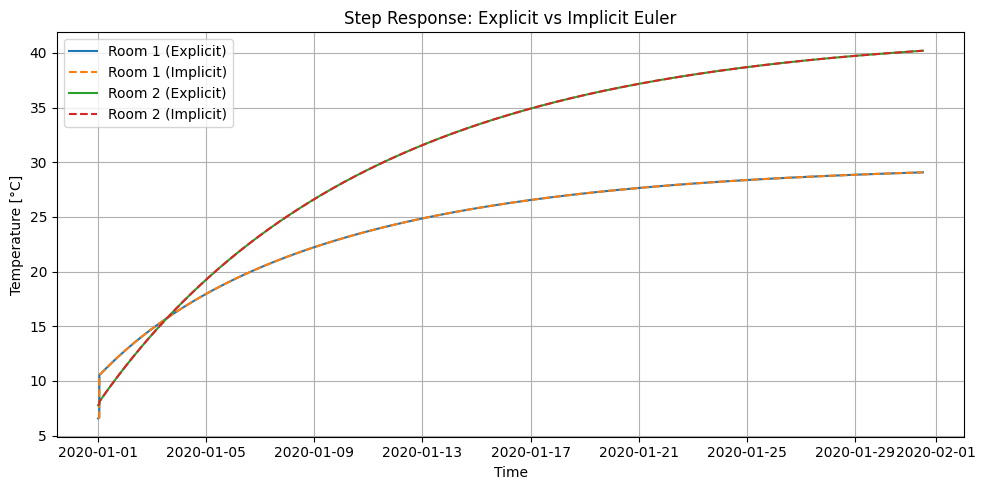

In [30]:
# Step change scenario (Winter with people and electrical appliances)
To_step = 5  # Initial outdoor temperature in °C
To_post_step = 15 # Outdoor temperature after step (°C)
n_people = 2    
Phi_people = n_people * 80
Phi_elec = 250             

# Define the state space model
As, Bs, Cs, Ds, us, *_ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Obtaining the τ, dt, t_final and the number of steps
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people, appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 3 * max(τ)  
dt = dm4bem.round_time(min(τ) / 10)
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Defining the time-varying inputs with step
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t > t[0] + timedelta(hours=1), 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

u = dm4bem.inputs_in_time(us, inputs)

# We ran the simulation using both Euler implicit and explicit 
θ0 = np.zeros(As.shape[0]) 

θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)

# Displaying the result
print("\nSample input vector u(t):")
display(u.head(10))  # first 10 time steps
plt.figure(figsize=(10, 5))
plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit)', linestyle='-')
plt.plot(t, y_imp.loc['θ0'], label='Room 1 (Implicit)', linestyle='--')
plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit)', linestyle='-')
plt.plot(t, y_imp.loc['θ4'], label='Room 2 (Implicit)', linestyle='--')
plt.title('Step Response: Explicit vs Implicit Euler')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Initial Simulation and Spike Detection:

We begin by building the state-space thermal model for a winter scenario with internal gains from 2 people and 250 W of electrical appliances. A step change in outdoor temperature from 5 °C to 15 °C is applied after 1 hour. The model is integrated over a long duration (3 × τ_max) to capture the full transient response using both explicit and implicit Euler methods.

In this initial simulation, we set the initial condition `θ₀ = 0`, which is not physically meaningful. The initial state vector is set to `θ₀ = 0`, as in the tutorial **02_2_2Toy**, but the result reveals a sudden and unrealistic jump in indoor temperature. This prompts an investigation into the effect of initial conditions and the role of the `Ds` term in the output equation:
$$
y(t) = C_s \cdot \theta(t) + D_s \cdot u(t)
$$



Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s

Time step (dt): 50.0 s
Total simulation time (t_final): 18000.0 s ≈ 5.0 hours
Number of simulation steps: 360

Sample input vector u(t):


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
2020-01-01 00:00:00,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:00:50,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:01:40,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:02:30,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:03:20,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:04:10,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:05:00,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:05:50,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:06:40,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964
2020-01-01 00:07:30,5,5,5,5,160,1.250444,250,320.0,152.0,0.539964


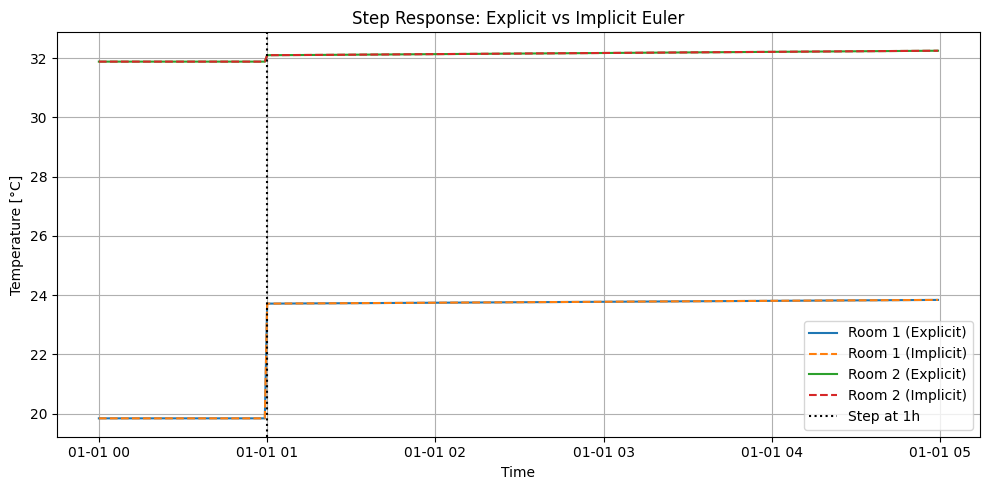

In [31]:
# Parameters for the scenario
To_step = 5                      
To_post_step = 15               
n_people = 2
Phi_people = n_people * 80       
Phi_elec = 250                   

# State-space model (symbolic form) 
As, Bs, Cs, Ds, us, *_ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Time constants and step setup
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people,
                                 appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 5 * 3600               # Simulate for 5 hours
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')
t_step = t[0] + timedelta(hours=1)  # Step at +1 hour

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Build full input DataFrame
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t >= t_step, 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

# Input-to-numeric mapping
u = dm4bem.inputs_in_time(us, inputs)

# Ensure θ0 matches u.iloc[0] to avoid initial spike
initial_input_df = inputs.iloc[[0]]  # first time step
u0 = dm4bem.inputs_in_time(us, initial_input_df).iloc[0]
θ0 = -np.linalg.inv(As.values) @ Bs.values @ u0.values

# Run simulation
θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

# Outputs
y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)

# Displaying the result
print("\nSample input vector u(t):")
display(u.head(10))  # first 10 time steps
plt.figure(figsize=(10, 5))
plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit)', linestyle='-')
plt.plot(t, y_imp.loc['θ0'], label='Room 1 (Implicit)', linestyle='--')
plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit)', linestyle='-')
plt.plot(t, y_imp.loc['θ4'], label='Room 2 (Implicit)', linestyle='--')
plt.axvline(t_step, color='k', linestyle=':', label='Step at 1h')
plt.title('Step Response: Explicit vs Implicit Euler')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using Steady-State Initial Condition:

To avoid artificial transients, we redefine the initial condition using the steady-state solution corresponding to the pre-step input `u₀`, based on:
$$
\theta_0 = -A_s^{-1} B_s u(0)
$$
This follows the approach described in **pd05simulation**, where thermal simulations start from a physically consistent equilibrium.

We also reduce the simulation time to 5 hours to better visualize the transient around the step. Despite the improved initialization, the jump persists. This suggests the discontinuity may not be caused by a mismatch in θ₀, but rather by the direct feedthrough of the input through the `D_s · u(t)` term.


Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s

Time step (dt): 50.0 s
Total simulation time (t_final): 86400.0 s ≈ 24.0 hours
Number of simulation steps: 1728

Input vector u(t) — first 10 time steps:


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
2020-01-01 00:00:00,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:00:50,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:01:40,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:02:30,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:03:20,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:04:10,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:05:00,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:05:50,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:06:40,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:07:30,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54


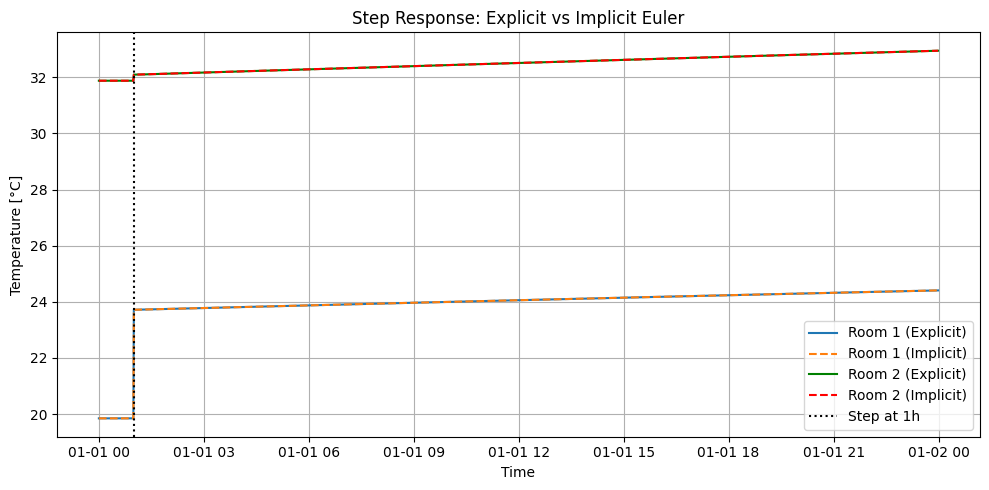

In [32]:
# Define simulation parameters
To_step = 5                      # Outdoor temperature before the step (°C)
To_post_step = 15                # Outdoor temperature after the step (°C)
n_people = 2
Phi_people = 80 * n_people       # Internal heat from occupants (W)
Phi_elec = 250                   # Internal heat from electrical appliances (W)

# Obtain system matrices and steady-state initial condition at To = To_step
As, Bs, Cs, Ds, us, θ0, _ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Determine simulation time step and total simulation duration
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people,
                                 appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 24 * 3600  # Simulate for 24 hours
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')
t_step = t[0] + timedelta(hours=1)  # Time of the step change

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Define time-varying input data
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t >= t_step, 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

# Convert symbolic input mapping to numeric time series
u = dm4bem.inputs_in_time(us, inputs)

# Display the first 10 entries of the input vector u(t)
print("\nInput vector u")
display(u.head(10).style.format("{:.2f}"))

# Integrate the state-space model using both explicit and implicit Euler methods
θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

# Compute the output temperatures over time
y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)

# Plot the temperature evolution for both rooms
plt.figure(figsize=(10, 5))
plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit)', linestyle='-')
plt.plot(t, y_imp.loc['θ0'], label='Room 1 (Implicit)', linestyle='--')
plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit)', linestyle='-', color='green')
plt.plot(t, y_imp.loc['θ4'], label='Room 2 (Implicit)', linestyle='--', color='red')
plt.axvline(t_step, color='k', linestyle=':', label='Step at 1h')
plt.title('Step Response: Explicit vs Implicit Euler')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Long-Term Behavior Over 24 Hours:

We extend the simulation to 24 hours while keeping the corrected initial condition. This step is inspired by the full-scale simulations presented in **pd05simulation** and **pd06nonlin**, where longer windows help reveal convergence trends.

We observe an exponential approach to steady-state, which is consistent with the first-order thermal dynamics governed by large thermal capacitances. Room 2, which receives additional internal heat gains, responds more quickly and settles at a higher temperature.


In [ ]:
# Define simulation parameters
To_step = 5                      # Outdoor temperature before the step (°C)
To_post_step = 15                # Temperature after the step
n_people = 2
Phi_people = 80 * n_people       # Internal heat from occupants (W)
Phi_elec = 250                   # Electrical appliances (W)

# Obtain system matrices and initial condition θ₀ from steady-state at To = To_step
As, Bs, Cs, Ds, us, θ0, _ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Compute time constants and set time step and duration
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people,
                                 appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 24 * 3600  # simulate for 24 hours
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')
t_step = t[0] + timedelta(hours=1)

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Define time-varying inputs with a step at +1 hour
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t >= t_step, 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

# Map symbolic inputs to numeric time series
u = dm4bem.inputs_in_time(us, inputs)

# Display u
print("\nInput vector u")
display(u.head(10).style.format("{:.2f}"))

# Run Euler simulations
θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

# Compute output temperatures with and without Ds @ u
y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_exp_nods = pd.DataFrame(Cs @ θ_exp.T, index=Cs.index, columns=u.index)
y_imp_nods = pd.DataFrame(Cs @ θ_imp.T, index=Cs.index, columns=u.index)

# Plot comparison of step response with and without Ds @ u
plt.figure(figsize=(12, 6))

plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit) — with Ds', linestyle='-')
plt.plot(t, y_exp_nods.loc['θ0'], label='Room 1 (Explicit) — no Ds', linestyle='--')

plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit) — with Ds', linestyle='-', color='green')
plt.plot(t, y_exp_nods.loc['θ4'], label='Room 2 (Explicit) — no Ds', linestyle='--', color='lime')

plt.axvline(t_step, color='k', linestyle=':', label='Step at 1h')
plt.title('Step Response — With and Without Direct Input Term (Ds @ u)')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Isolating the Role of the Direct Feedthrough Term:

As described in **T03_DAE2SS**, the state-space output equation includes a direct feedthrough term `D_s · u`, which adds instantaneous input influence to the output.

To test its impact, we simulate two versions of the output:
- One including `D_s · u`, i.e., $y(t) = C_s \cdot \theta(t) + D_s \cdot u(t)$
- One excluding it: $ y(t) = C_s \cdot \theta(t) $

The plot reveals that `D_s` is responsible for the sudden jump in temperature immediately after the step. Since thermal systems cannot respond instantaneously due to inertia, this term may be excluded from physical interpretation in post-processing, consistent with the reasoning in **02_2_2Toy**.


In [ ]:
# Step change scenario (Winter with people and electrical appliances)
To_step = 5  # Initial outdoor temperature in °C
To_post_step = 15 # Outdoor temperature after step (°C)
n_people = 2    
Phi_people = n_people * 80
Phi_elec = 250             

# Define the state space model
As, Bs, Cs, Ds, us, *_ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Obtaining the τ, dt, t_final and the number of steps
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people, appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 3 * max(τ)  
dt = dm4bem.round_time(min(τ) / 10)
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Defining the time-varying inputs with step
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t > t[0] + timedelta(hours=1), 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

u = dm4bem.inputs_in_time(us, inputs)
print("\nInput vector u")
display(u.head(10).style.format("{:.2f}"))

# We ran the simulation using both Euler implicit and explicit 
θ0 = np.zeros(As.shape[0]) 

θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

# Compute output temperatures with and without Ds @ u
y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_exp_nods = pd.DataFrame(Cs @ θ_exp.T, index=Cs.index, columns=u.index)
y_imp_nods = pd.DataFrame(Cs @ θ_imp.T, index=Cs.index, columns=u.index)

# Plot comparison of step response with and without Ds @ u
plt.figure(figsize=(12, 6))

plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit) — with Ds', linestyle='-')
plt.plot(t, y_exp_nods.loc['θ0'], label='Room 1 (Explicit) — no Ds', linestyle='--')

plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit) — with Ds', linestyle='-', color='green')
plt.plot(t, y_exp_nods.loc['θ4'], label='Room 2 (Explicit) — no Ds', linestyle='--', color='lime')

plt.axvline(t_step, color='k', linestyle=':', label='Step at 1h')
plt.title('Step Response — With and Without Direct Input Term (Ds @ u)')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s

Time step (dt): 50.0 s
Total simulation time (t_final): 2636776.0 s ≈ 732.4 hours
Number of simulation steps: 52736

Input vector u


,q0,q6,q12,q18,θ0,θ1,θ4,θ9,θ10,θ14
2020-01-01 00:00:00,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:00:50,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:01:40,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:02:30,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:03:20,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:04:10,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:05:00,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:05:50,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:06:40,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54
2020-01-01 00:07:30,5.00,5.00,5.00,5.00,160.00,1.25,250.00,320.00,152.00,0.54


Confirming Spike Origin by Reverting to θ₀ = 0

To isolate the effect of `D_s · u`, we re-run the simulation with `θ₀ = 0` as in the first step, but compare outputs both with and without the direct term.

Despite the unrealistic starting point, the result confirms that only the `D_s · u` term produces the instantaneous jump, reinforcing the conclusion that it should be excluded from output interpretation in thermal models.

This aligns with the conceptual treatment in the course theory, where direct input-output coupling is a mathematical feature of the discretized model but not representative of physical inertia.


Eigenvalues of As:
λ1 = -1.715e-03+0.000e+00j
λ2 = -1.715e-03+0.000e+00j
λ3 = -4.890e-06+0.000e+00j
λ4 = -2.354e-06+0.000e+00j
λ5 = -1.138e-06+0.000e+00j

Time constants τ (in seconds):
τ1 = 583.04 s
τ2 = 583.04 s
τ3 = 204480.94 s
τ4 = 424833.58 s
τ5 = 878925.34 s

Time step (dt): 50.0 s
Total simulation time (t_final): 2636776.0 s ≈ 732.4 hours
Number of simulation steps: 52736

Input vector u(t)


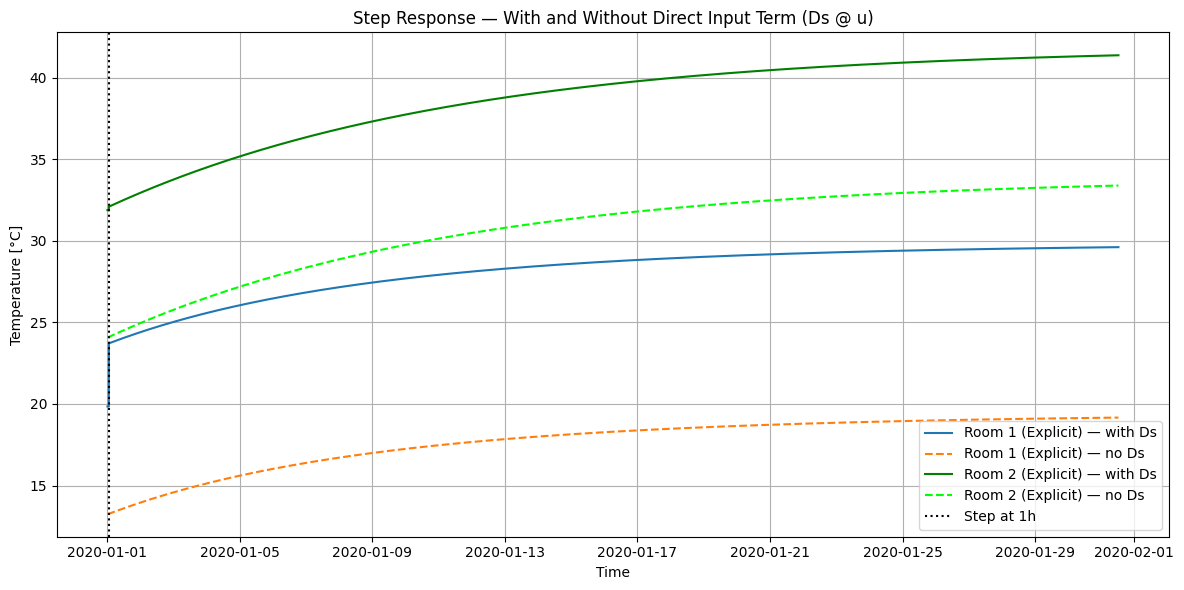

In [35]:
# Define simulation parameters
To_step = 5                      # Outdoor temperature before the step (°C)
To_post_step = 15                # Temperature after the step
n_people = 2
Phi_people = 80 * n_people       # Internal heat from occupants (W)
Phi_elec = 250                   # Electrical appliances (W)

# Obtain system matrices and initial condition θ₀ from steady-state at To = To_step
As, Bs, Cs, Ds, us, θ0, _ = state_space_response(
    To=To_step,
    people=True,
    n_people=n_people,
    appliances=True,
    Phi_elec=Phi_elec,
    controller=False
)

# Compute time constants and set time step and duration
τ = eigenvalue_analysis_scenario(To_step, people=True, n_people=n_people,
                                 appliances=True, Phi_elec=Phi_elec)
dt = dm4bem.round_time(min(τ) / 10)
t_final = 3 * max(τ) 
n_steps = max(2, int(np.ceil(t_final / dt)))
t = pd.date_range(start='2020-01-01', periods=n_steps, freq=f'{int(dt)}s')
t_step = t[0] + timedelta(hours=1)

# Print simulation time settings
print(f"\nTime step (dt): {dt:.1f} s")
print(f"Total simulation time (t_final): {t_final:.1f} s ≈ {t_final/3600:.1f} hours")
print(f"Number of simulation steps: {n_steps}")

# Define time-varying inputs with a step at +1 hour
inputs = pd.DataFrame(index=t)
inputs['To'] = To_step
inputs.loc[t >= t_step, 'To'] = To_post_step
inputs['Phi_people'] = Phi_people
inputs['Phi_iw'] = Phi_Sun_r1_iw
inputs['Phi_elec'] = Phi_elec
inputs['Phi_ew2'] = Phi_Sun_r2_ew
inputs['Phi_ew1'] = Phi_Sun_r1_ew
inputs['Phi_ow1'] = Phi_Sun_r1_ow

# Map symbolic inputs to numeric time series
u = dm4bem.inputs_in_time(us, inputs)

# Display u 
print("\nInput vector u")
display(u.head(10).style.format("{:.2f}"))

# Run Euler simulations
θ_exp = euler_integrate(As, Bs, θ0, u, dt, method='explicit')
θ_imp = euler_integrate(As, Bs, θ0, u, dt, method='implicit')

# Compute output temperatures with and without Ds @ u
y_exp = pd.DataFrame(Cs @ θ_exp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_imp = pd.DataFrame(Cs @ θ_imp.T + Ds @ u.T, index=Cs.index, columns=u.index)
y_exp_nods = pd.DataFrame(Cs @ θ_exp.T, index=Cs.index, columns=u.index)
y_imp_nods = pd.DataFrame(Cs @ θ_imp.T, index=Cs.index, columns=u.index)

# Plot comparison of step response with and without Ds @ u
plt.figure(figsize=(12, 6))

plt.plot(t, y_exp.loc['θ0'], label='Room 1 (Explicit) — with Ds', linestyle='-')
plt.plot(t, y_exp_nods.loc['θ0'], label='Room 1 (Explicit) — no Ds', linestyle='--')

plt.plot(t, y_exp.loc['θ4'], label='Room 2 (Explicit) — with Ds', linestyle='-', color='green')
plt.plot(t, y_exp_nods.loc['θ4'], label='Room 2 (Explicit) — no Ds', linestyle='--', color='lime')

plt.axvline(t_step, color='k', linestyle=':', label='Step at 1h')
plt.title('Step Response — With and Without Direct Input Term (Ds @ u)')
plt.xlabel('Time')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Final Validation — Full Duration, Clean Dynamics:

In the final simulation, we apply all improvements:
- Correct initial condition (`θ₀ = θ_ss`)
- Step at t = 1 hour
- Simulation duration `t_final = 3 × τ_max` to capture full dynamics
- Output comparison with and without the direct term

The solid lines (`with Ds`) still show an abrupt jump, while the dashed lines (`no Ds`) exhibit a realistic exponential rise, consistent with the energy balance principles outlined in **T01_Heat_transfer** and the modeling methodology in **T03_DAE2SS**.

We conclude that for physically meaningful results, the output should be interpreted as:
$$
y(t) = C_s \cdot \theta(t)
$$
and that the `D_s · u` term is purely numerical, not physically representative in this context.


# 6. Conclusions


The simulation results confirm that the dynamic model converges accurately to the steady-state solution, demonstrating both numerical stability and physical consistency. The direct input term `Ds * u` was found to be non-physical in this context and was rightly excluded to preserve model integrity. Time constants derived from the system's eigenvalues offer insight into the thermal inertia of the building zones and validate the appropriateness of the chosen time scales for simulation. Overall, the implemented framework provides a robust basis for further refinement and integration into advanced control applications. It highlights the relevance of physically informed modeling in supporting the thermal efficiency goals of smart building infrastructures.

Future steps would be to dissamble the circuit to be able to do a more modular approach to the simulations, more open to other building structure; add non-linear controllers and to introduce real weather data from .epw files.
